In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_probability as tfp

import corner 
import math as m

from HessianMCMC import HessianMCMC
from Grav_polygon import constant64,Gravity_Polygon
from GaussianProcess import GaussianProcess2Dlayer


#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [2]:
## define some numbers
Number_para = 5
obs_N = 25
number_burnin = 3000
number_sample = 10000
steps_gradient_decent = 2000

pi = constant64(m.pi) # define PI in Tensorflow form

depth = constant64(-50)
thickness = constant64(10)

Range = constant64([-200.,200.])

In [3]:
# prior
mu_prior = -50.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 15.*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)

rho = 2000
# likelihood
sig_e = constant64(2*1e-8)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

In [4]:
model = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para)

In [5]:
model.set_prior(mu_prior,cov_prior,cov)

## Define the ground truth

In [6]:
tf.random.set_seed(8)

# X- values: uniformly distributed
control_index = tf.linspace(Range[0],Range[1],Number_para)
# control_index with non-even distribution
# control_index = tf.linspace(Range[0],Range[1],Number_para)+tf.random.uniform([Number_para],-20,20,dtype = tf.float64)

## define the true z-values

True_position_sin = 20*tf.sin(0.01*control_index)+depth
gp = GaussianProcess2Dlayer(Range,depth,Number_para,thickness,)
x_true,z_true =gp.GaussianProcess(control_index,True_position_sin)

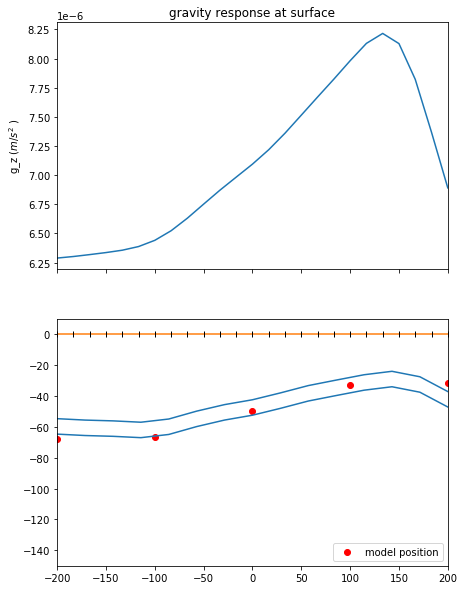

In [8]:
def simulated_gravity(x,z,x_obs=None,Number_=obs_N ,R=Range[1],ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T

    gravity = model.calculate_gravity(x,z)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')

    ax.set_xlim(-R,R)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

def Draw_inter(_control_index,_control_position,z_true = None,R = Range[1], ax = None):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is not None:
        ## true poistion is black
        ax.scatter(control_index,z_true, c = 'black',label = 'true position',alpha = 0.6)
        
    x_,z_ = gp.GaussianProcess(_control_index,_control_position)
    ax.plot(x_,z_)
    ## proposal is red
    ax.scatter(control_index,_control_position, label = 'model position',c = 'red')

    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(depth-100,10)
    ax.set_xlim(-R,R)
    
def Draw(_control_index,_control_position,true_position = None,ax = None,**args):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    _x,_z = gp.GaussianProcess(_control_index,_control_position)
    simulated_gravity(_x,_z,ax = ax[0],**args)
    Draw_inter(_control_index,_control_position,ax = ax[1],z_true =true_position)
    plt.legend(loc = 'lower right')
    
Draw(control_index,True_position_sin)

In [10]:
mu_init = tf.random.normal([Number_para],mean = depth, stddev = -10,seed = 2,dtype = tf.float64) # initial parameters
mu = mu_init
model.joint_log_post(Data,mu_init)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


<tf.Tensor: shape=(), dtype=float64, numpy=-23068.575265546173>

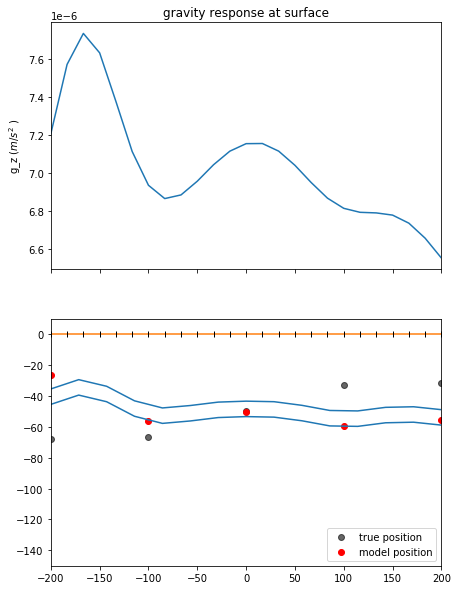

In [11]:
Draw(control_index,mu_init,True_position_sin)

###  TODO: gradient decent
 - Nelder–Mead method
 - Broyden–Fletcher–Goldfarb–Shanno algorithm

mu [-26.51758501 -56.04498254 -50.6410808  -59.42099511 -55.85079152]
loss 23068.575265546173
dmu [ 454.76782146  509.31248312  -14.88499197 -626.42995301 -262.86071273]
mu [-26.56306179 -56.09591379 -50.6395923  -59.35835212 -55.82450545]
loss 22975.884155501197
dmu [ 453.62139488  507.58088035  -14.64580525 -625.45873924 -262.66300341]
mu [-26.60842393 -56.14667188 -50.63812772 -59.29580624 -55.79823915]
loss 22883.605374727355
dmu [ 452.48030448  505.85651084  -14.40868646 -624.48766985 -262.46526185]
mu [-26.65367196 -56.19725753 -50.63668685 -59.23335748 -55.77199262]
loss 22791.736620684875
dmu [ 451.34451273  504.13932855  -14.17362114 -623.51674474 -262.26748807]
mu [-26.69880641 -56.24767146 -50.63526949 -59.1710058  -55.74576587]
loss 22700.27561036511
dmu [ 450.2139825   502.42928787  -13.94059494 -622.54596388 -262.06968211]
mu [-26.74382781 -56.29791439 -50.63387543 -59.10875121 -55.7195589 ]
loss 22609.220080059913
dmu [ 449.08867698  500.72634362  -13.70959362 -621.57532

mu [-28.98075624 -58.73330467 -50.58846856 -55.94778456 -54.35897685]
loss 18310.370733807216
dmu [ 396.07277077  419.5768743    -4.0293134  -570.3507295  -251.34306581]
mu [-29.02036352 -58.77526236 -50.58806563 -55.89074949 -54.33384255]
loss 18238.306405787676
dmu [ 395.18330518  418.2000677    -3.88935073 -569.38882841 -251.1436652 ]
mu [-29.05988185 -58.81708236 -50.5876767  -55.83381061 -54.30872818]
loss 18166.547196445543
dmu [ 394.29748127  416.82840224   -3.75078027 -568.42712269 -250.94424055]
mu [-29.0993116  -58.8587652  -50.58730162 -55.77696789 -54.28363376]
loss 18095.091636260615
dmu [ 393.41527672  415.46185016   -3.61359275 -567.46561408 -250.7447921 ]
mu [-29.13865313 -58.90031139 -50.58694026 -55.72022133 -54.25855928]
loss 18023.93826593816
dmu [ 392.53666938  414.10038392   -3.47777899 -566.50430436 -250.54532008]
mu [-29.17790679 -58.94172143 -50.58659248 -55.6635709  -54.23350475]
loss 17953.08563630254
dmu [ 391.66163732  412.7439762    -3.34332986 -565.543195

mu [-31.10625735 -60.9191869  -50.58410602 -52.84965426 -52.95820589]
loss 14650.312885327667
dmu [ 350.5981336   348.57150732    1.97374743 -515.89448832 -239.94657336]
mu [-31.14131716 -60.95404405 -50.5843034  -52.79806481 -52.93421123]
loss 14593.557117823826
dmu [ 349.88536639  347.44917762    2.04741583 -514.94717623 -239.74623864]
mu [-31.1763057  -60.98878897 -50.58450814 -52.74657009 -52.91023661]
loss 14537.036371465367
dmu [ 349.17521585  346.33070572    2.12013003 -514.00019389 -239.54589652]
mu [-31.21122322 -61.02342204 -50.58472015 -52.69517007 -52.88628202]
loss 14480.749622507261
dmu [ 348.46766772  345.21607362    2.19189637 -513.05354416 -239.34554733]
mu [-31.24606999 -61.05794365 -50.58493934 -52.64386472 -52.86234746]
loss 14424.695853046334
dmu [ 347.76270784  344.10526343    2.26272109 -512.10722997 -239.14519142]
mu [-31.28084626 -61.09235418 -50.58516561 -52.59265399 -52.83843294]
loss 14368.874050967297
dmu [ 347.06032216  342.99825738    2.33261043 -511.1612

mu [-33.09199788 -62.82435055 -50.60601004 -49.92068527 -51.55399366]
loss 11628.50735417712
dmu [ 312.02185132  287.49971644    4.90307743 -459.74440911 -227.92568688]
mu [-33.12320007 -62.85310052 -50.60650035 -49.87471083 -51.5312011 ]
loss 11584.217763560431
dmu [ 311.44400631  286.58080594    4.92944348 -458.8224099  -227.72555363]
mu [-33.15434447 -62.8817586  -50.60699329 -49.82882859 -51.50842854]
loss 11540.110549576046
dmu [ 310.86807913  285.66486236    4.95517321 -457.90093379 -227.52543545]
mu [-33.18543128 -62.91032508 -50.60748881 -49.7830385  -51.485676  ]
loss 11496.184962574116
dmu [ 310.29406041  284.7518736     4.98027102 -456.97998424 -227.32533274]
mu [-33.21646068 -62.93880027 -50.60798684 -49.7373405  -51.46294346]
loss 11452.440256423606
dmu [ 309.72194083  283.84182762    5.00474128 -456.05956472 -227.12524589]
mu [-33.24743288 -62.96718446 -50.60848731 -49.69173454 -51.44023094]
loss 11408.875688487042
dmu [ 309.15171113  282.93471245    5.02858834 -455.13967

mu [-34.86798708 -64.39630158 -50.63811952 -47.32345176 -50.22179186]
loss 9269.86883976428
dmu [ 280.45218473  237.23518337    5.49799952 -405.47044043 -215.95822548]
mu [-34.8960323  -64.4200251  -50.63866932 -47.28290472 -50.20019604]
loss 9235.303780595897
dmu [ 279.97468932  236.4751182     5.49319499 -404.58604995 -215.75971587]
mu [-34.92402977 -64.44367261 -50.63921864 -47.24244611 -50.17862006]
loss 9200.881557920957
dmu [ 279.49864262  235.71740595    5.48797911 -403.70239369 -215.56124584]
mu [-34.95197963 -64.46724435 -50.63976744 -47.20207587 -50.15706394]
loss 9166.60159442679
dmu [ 279.02403818  234.96203804    5.48235502 -402.81947512 -215.36281581]
mu [-34.97988203 -64.49074055 -50.64031568 -47.16179393 -50.13552766]
loss 9132.463315134684
dmu [ 278.55086959  234.20900595    5.47632587 -401.93729773 -215.16442619]
mu [-35.00773712 -64.51416145 -50.64086331 -47.1216002  -50.11401122]
loss 9098.466147385558
dmu [ 278.07913049  233.45830116    5.46989478 -401.05586499 -21

mu [-36.41989299 -65.65354244 -50.66807106 -45.11550212 -49.00190826]
loss 7484.322292197097
dmu [ 254.96837895  196.793787      4.63005468 -355.49457768 -204.52271954]
mu [-36.44538983 -65.67322182 -50.66853406 -45.07995266 -48.98145599]
loss 7457.154155587877
dmu [ 254.56532778  196.15727368    4.60612851 -354.65834833 -204.32717924]
mu [-36.47084636 -65.69283755 -50.66899468 -45.04448683 -48.96102327]
loss 7430.098853986255
dmu [ 254.16340696  195.52268115    4.58194895 -353.82304461 -204.13170194]
mu [-36.4962627  -65.71238982 -50.66945287 -45.00910452 -48.9406101 ]
loss 7403.1559262750925
dmu [ 253.76261185  194.89000298    4.55751832 -352.98866956 -203.93628804]
mu [-36.52163896 -65.73187882 -50.66990862 -44.97380565 -48.92021647]
loss 7376.32491305941
dmu [ 253.36293785  194.25923277    4.53283892 -352.15522622 -203.74093793]
mu [-36.54697525 -65.75130474 -50.67036191 -44.93859013 -48.89984238]
loss 7349.605356658827
dmu [ 252.96438038  193.63036413    4.50791304 -351.32271762 -

mu [-37.85872005 -66.71168377 -50.69057053 -43.15802087 -47.82845887]
loss 6060.22057185112
dmu [ 232.98243183  162.32931831    2.85495485 -307.83457529 -193.10604765]
mu [-37.88201829 -66.7279167  -50.69085603 -43.12723742 -47.80914827]
loss 6038.973523260988
dmu [ 232.63889034  161.79599924    2.81967363 -307.05778694 -192.91487116]
mu [-37.90528218 -66.7440963  -50.69113799 -43.09653164 -47.78985678]
loss 6017.814828010427
dmu [ 232.29624386  161.26426602    2.78425667 -306.2820831  -192.72377951]
mu [-37.9285118  -66.76022272 -50.69141642 -43.06590343 -47.7705844 ]
loss 5996.744115355913
dmu [ 231.95448896  160.73411364    2.74870566 -305.50746606 -192.53277305]
mu [-37.95170725 -66.77629614 -50.69169129 -43.03535268 -47.75133113]
loss 5975.76101591913
dmu [ 231.61362228  160.20553714    2.71302228 -304.73393809 -192.34185211]
mu [-37.97486861 -66.79231669 -50.69196259 -43.00487929 -47.73209694]
loss 5954.865161681755
dmu [ 231.27364043  159.67853157    2.67720818 -303.96150145 -19

mu [-39.06978177 -67.51572584 -50.70065239 -41.60411509 -46.81282252]
loss 5030.535216333137
dmu [ 215.63252498  135.68159877    0.79457402 -267.49179838 -182.91217699]
mu [-39.09134502 -67.529294   -50.70073185 -41.57736591 -46.79453131]
loss 5013.561175716099
dmu [ 215.33283033  135.22723335    0.75415999 -266.77646314 -182.72605133]
mu [-39.1128783  -67.54281673 -50.70080727 -41.55068826 -46.7762587 ]
loss 4996.65731395953
dmu [ 215.03386868  134.7742101     0.71368902 -266.06231366 -182.54002771]
mu [-39.13438169 -67.55629415 -50.70087864 -41.52408203 -46.7580047 ]
loss 4979.8233279861415
dmu [ 214.7356374   134.32252495    0.67316237 -265.34935137 -182.35410641]
mu [-39.15585525 -67.5697264  -50.70094595 -41.4975471  -46.73976929]
loss 4963.058915867632
dmu [ 214.43813388  133.87217387    0.63258125 -264.63757768 -182.16828774]
mu [-39.17729907 -67.58311362 -50.70100921 -41.47108334 -46.72155246]
loss 4946.363776820417
dmu [ 214.14135553  133.42315279    0.59194689 -263.92699402 -

mu [-40.21309359 -68.19788871 -50.69891152 -40.23598335 -45.83416804]
loss 4193.607465101972
dmu [ 200.17292493  112.58263766   -1.48261526 -229.94132365 -172.83399265]
mu [-40.23311089 -68.20914697 -50.69876326 -40.21298922 -45.81688464]
loss 4180.072193567825
dmu [ 199.90994704  112.19640906   -1.52450205 -229.29291038 -172.65387855]
mu [-40.25310188 -68.22036661 -50.69861081 -40.19005993 -45.79961926]
loss 4166.592051121541
dmu [ 199.64757427  111.81131866   -1.56638772 -228.64573774 -172.47388068]
mu [-40.27306664 -68.23154774 -50.69845417 -40.16719535 -45.78237187]
loss 4153.16679305786
dmu [ 199.38580459  111.4273631    -1.60827142 -227.99980625 -172.29399926]
mu [-40.29300522 -68.24269048 -50.69829335 -40.14439537 -45.76514247]
loss 4139.796175648084
dmu [ 199.12463595  111.04453901   -1.65015225 -227.35511647 -172.11423453]
mu [-40.31291768 -68.25379493 -50.69812833 -40.12165986 -45.74793104]
loss 4126.4799561363625
dmu [ 198.86406634  110.66284304   -1.69202936 -226.71166889 -

mu [-41.35099671 -68.79959461 -50.68303799 -38.98622271 -44.84487751]
loss 3481.827233836655
dmu [ 185.62994272   91.63779343   -3.92605283 -193.81846542 -162.41290653]
mu [-41.36955971 -68.80875839 -50.68264538 -38.96684086 -44.82863622]
loss 3471.1563333178033
dmu [ 185.39943734   91.31328678   -3.96655214 -193.24369063 -162.23999645]
mu [-41.38809965 -68.81788972 -50.68224873 -38.94751649 -44.81241222]
loss 3460.5277030033153
dmu [ 185.16943026   90.98973673   -4.00700782 -192.67016303 -162.06721384]
mu [-41.4066166  -68.82698869 -50.68184803 -38.92824947 -44.79620549]
loss 3449.941151011512
dmu [ 184.93991986   90.66714048   -4.04741929 -192.09788229 -161.89455887]
mu [-41.42511059 -68.8360554  -50.68144329 -38.90903969 -44.78001604]
loss 3439.396486275558
dmu [ 184.71090457   90.34549523   -4.087786   -191.52684808 -161.72203169]
mu [-41.44358168 -68.84508995 -50.68103451 -38.889887   -44.76384384]
loss 3428.893518539962
dmu [ 184.48238282   90.02479821   -4.12810737 -190.95706007

mu [-42.40832447 -69.28772098 -50.65311051 -37.93700417 -43.91580536]
loss 2918.688375633132
dmu [ 172.83376759   74.04132194   -6.22425109 -162.0245362  -152.43385558]
mu [-42.42560785 -69.29512511 -50.65248809 -37.92080172 -43.90056198]
loss 2910.2084193009237
dmu [ 172.63013628   73.76872573   -6.26133722 -161.52239107 -152.26869556]
mu [-42.44287086 -69.30250198 -50.65186195 -37.90464948 -43.88533511]
loss 2901.7607227294975
dmu [ 172.42691956   73.49693446   -6.29835316 -161.02145324 -152.10367026]
mu [-42.46011355 -69.30985168 -50.65123212 -37.88854733 -43.87012474]
loss 2893.345137751164
dmu [ 172.22411617   73.22594579   -6.33529855 -160.52172167 -151.93877977]
mu [-42.47733597 -69.31717427 -50.65059859 -37.87249516 -43.85493086]
loss 2884.961516866071
dmu [ 172.02172485   72.95575736   -6.37217308 -160.02319536 -151.77402417]
mu [-42.49453814 -69.32446985 -50.64996137 -37.85649284 -43.83975346]
loss 2876.6097132382006
dmu [ 171.81974437   72.68636685   -6.40897641 -159.5258732

mu [-43.34593925 -69.66252013 -50.61274911 -37.10369144 -43.08723404]
loss 2489.619598156176
dmu [ 162.03577847   59.9528586    -8.18485457 -135.73202421 -143.39449452]
mu [-43.36214283 -69.66851541 -50.61193063 -37.09011824 -43.07289459]
loss 2482.735634377745
dmu [ 161.85355772   59.72190341   -8.21758158 -135.29566646 -143.23699008]
mu [-43.37832819 -69.6744876  -50.61110887 -37.07658868 -43.05857089]
loss 2475.8765952159406
dmu [ 161.67168816   59.49163158   -8.25022443 -134.86044527 -143.07962389]
mu [-43.39449535 -69.68043676 -50.61028385 -37.06310263 -43.04426293]
loss 2469.0423662802423
dmu [ 161.4901688    59.26204111   -8.28278296 -134.42635915 -142.922396  ]
mu [-43.41064437 -69.68636297 -50.60945557 -37.04966    -43.02997069]
loss 2462.232833719586
dmu [ 161.30899863   59.03312999   -8.31525699 -133.99340659 -142.76530642]
mu [-43.42677527 -69.69226628 -50.60862404 -37.03626065 -43.01569416]
loss 2455.447884220105
dmu [ 161.12817663   58.80489626   -8.34764638 -133.56158611

mu [-44.28705523 -69.9836023  -50.55814213 -36.36272136 -42.25427094]
loss 2117.035419930196
dmu [ 151.6912368    47.23944236   -9.99496032 -111.50830541 -134.18977433]
mu [-44.30222436 -69.98832624 -50.55714263 -36.35157053 -42.24085196]
loss 2111.461897606924
dmu [ 151.52841587   47.04614158  -10.02242256 -111.13730054 -134.04060114]
mu [-44.3173772  -69.99303085 -50.55614039 -36.3404568  -42.2274479 ]
loss 2105.9073199790855
dmu [ 151.36589147   46.85341393  -10.04979467 -110.76733278 -133.89156694]
mu [-44.33251379 -69.9977162  -50.55513541 -36.32938007 -42.21405875]
loss 2100.3716013820394
dmu [ 151.20366281   46.66125772  -10.07707662 -110.39840034 -133.74267173]
mu [-44.34763415 -70.00238232 -50.5541277  -36.31834023 -42.20068448]
loss 2094.8546565703596
dmu [ 151.04172906   46.46967128  -10.10426837 -110.03050141 -133.59391548]
mu [-44.36273833 -70.00702929 -50.55311728 -36.30733718 -42.18732509]
loss 2089.3564007159184
dmu [ 150.88008942   46.27865294  -10.13136989 -109.663634

mu [-45.09792932 -70.21616198 -50.49932882 -35.80186146 -41.53801535]
loss 1836.5138760033333
dmu [ 143.15604919   37.41650197  -11.37114848  -92.59493506 -126.19114786]
mu [-45.11224493 -70.21990363 -50.49819171 -35.79260197 -41.52539623]
loss 1831.8654885413941
dmu [ 143.00840176   37.25234969  -11.39364214  -92.27822444 -126.04958631]
mu [-45.12654577 -70.22362887 -50.49705234 -35.78337414 -41.51279128]
loss 1827.2319102707024
dmu [ 142.86101012   37.08868493  -11.416046    -91.962448   -125.90816221]
mu [-45.14083187 -70.22733774 -50.49591074 -35.7741779  -41.50020046]
loss 1822.613075990623
dmu [ 142.7138736    36.92550627  -11.43836013  -91.64760383 -125.76687553]
mu [-45.15510326 -70.23103029 -50.4947669  -35.76501314 -41.48762377]
loss 1818.0089208261127
dmu [ 142.56699153   36.76281227  -11.46058457  -91.33369    -125.62572621]
mu [-45.16935996 -70.23470657 -50.49362084 -35.75587977 -41.4750612 ]
loss 1813.4193802265786
dmu [ 142.42036325   36.60060152  -11.48271937  -91.02070

mu [-45.8504576  -70.39588611 -50.43492667 -35.34491406 -40.87650121]
loss 1605.1740267450466
dmu [ 135.53318946   29.21565108  -12.45881567  -76.78141575 -118.74227347]
mu [-45.86401092 -70.39880768 -50.43368079 -35.33723592 -40.86462699]
loss 1601.2396490801036
dmu [ 135.39844931   29.07587339  -12.47655383  -76.5123815  -118.60805931]
mu [-45.87755077 -70.40171527 -50.43243313 -35.32958468 -40.85276618]
loss 1597.3169897645307
dmu [ 135.2639318    28.93651149  -12.49420622  -76.24417683 -118.47397953]
mu [-45.89107716 -70.40460892 -50.43118371 -35.32196026 -40.84091878]
loss 1593.405999131319
dmu [ 135.12963639   28.79756416  -12.51177291  -75.9767998  -118.34003408]
mu [-45.90459012 -70.40748867 -50.42993254 -35.31436258 -40.82908478]
loss 1589.506627763995
dmu [ 134.99556251   28.65903017  -12.52925402  -75.7102485  -118.20622289]
mu [-45.91808968 -70.41035458 -50.42867961 -35.30679156 -40.81726416]
loss 1585.6188264955038
dmu [ 134.86170962   28.5209083   -12.54664964  -75.444520

mu [-46.57644693 -70.53686548 -50.36399049 -34.96045707 -40.2429994 ]
loss 1404.9632358131546
dmu [ 128.4390711    22.11438756  -13.30987009  -63.16606414 -111.55814793]
mu [-46.58929084 -70.53907692 -50.3626595  -34.95414047 -40.23184358]
loss 1401.6057758752415
dmu [ 128.31579352   21.99575062  -13.32305564  -62.93981279 -111.43121448]
mu [-46.60212242 -70.5412765  -50.3613272  -34.94784649 -40.22070046]
loss 1398.2576435573683
dmu [ 128.19271044   21.87746719  -13.33616184  -62.71428639 -111.30441116]
mu [-46.61494169 -70.54346424 -50.35999358 -34.94157506 -40.20957002]
loss 1394.9188012460745
dmu [ 128.0698214    21.75953624  -13.34918884  -62.48948307 -111.17773788]
mu [-46.62774867 -70.5456402  -50.35865866 -34.93532611 -40.19845225]
loss 1391.5892115166293
dmu [ 127.94712593   21.64195673  -13.36213675  -62.26540099 -111.05119455]
mu [-46.64054338 -70.54780439 -50.35732245 -34.92909957 -40.18734713]
loss 1388.2688371328209
dmu [ 127.82462356   21.52472763  -13.37500572  -62.0420

mu [-47.21616203 -70.63523354 -50.29459082 -34.66569344 -39.68996807]
loss 1244.8872107761856
dmu [ 122.3905485    16.49370917  -13.88402451  -52.51338279 -105.24861042]
mu [-47.22840109 -70.63688291 -50.29320242 -34.6604421  -39.67944321]
loss 1241.961204162749
dmu [ 122.2766254    16.39183643  -13.89334015  -52.32177941 -105.12819942]
mu [-47.24062875 -70.6385221  -50.29181309 -34.65520993 -39.66893039]
loss 1239.0428285547582
dmu [ 122.16287479   16.29026786  -13.90258365  -52.13080906 -105.0079139 ]
mu [-47.25284504 -70.64015112 -50.29042283 -34.64999684 -39.6584296 ]
loss 1236.1320548172823
dmu [ 122.0492963    16.18900259  -13.91175515  -51.94046998 -104.88775376]
mu [-47.26504997 -70.64177003 -50.28903165 -34.6448028  -39.64794082]
loss 1233.2288539600256
dmu [ 121.93588951   16.08803972  -13.92085481  -51.75076044 -104.76771891]
mu [-47.27724355 -70.64337883 -50.28763957 -34.63962772 -39.63746405]
loss 1230.3331971361233
dmu [ 121.82265403   15.98737836  -13.92988277  -51.56167

mu [-47.91931733 -70.71606549 -50.21130887 -34.38666767 -39.08920011]
loss 1084.4243296641662
dmu [115.95186493  10.97578975 -14.31510575 -42.23663934 -98.35586969]
mu [-47.93091252 -70.71716306 -50.20987736 -34.382444   -39.07936453]
loss 1081.9030627125428
dmu [115.84747808  10.89041763 -14.32042356 -42.07950157 -98.24269328]
mu [-47.94249727 -70.71825211 -50.20844531 -34.37823605 -39.06954026]
loss 1079.3879313785442
dmu [115.74324228  10.80530128 -14.3256782  -41.92289915 -98.12963647]
mu [-47.95407159 -70.71933264 -50.20701275 -34.37404376 -39.05972729]
loss 1076.8789138413017
dmu [115.63915718  10.72043995 -14.33086982 -41.76683052 -98.01669916]
mu [-47.96563551 -70.72040468 -50.20557966 -34.36986708 -39.04992562]
loss 1074.3759883848786
dmu [115.53522247  10.63583289 -14.33599857 -41.61129412 -97.90388124]
mu [-47.97718903 -70.72146826 -50.20414606 -34.36570595 -39.04013524]
loss 1071.879133397946
dmu [115.43143781  10.55147937 -14.34106462 -41.45628839 -97.79118261]
mu [-47.988

mu [-48.57503544 -70.7663715  -50.12759061 -34.1660831  -38.53707947]
loss 947.7017307954123
dmu [110.13727644   6.42482118 -14.52386338 -33.9606337  -91.98614795]
mu [-48.58604916 -70.76701398 -50.12613822 -34.16268704 -38.52788086]
loss 945.5032679725647
dmu [110.04113117   6.35311309 -14.52577113 -33.83205675 -91.87973717]
mu [-48.59705328 -70.76764929 -50.12468565 -34.15930383 -38.51869288]
loss 943.3098321784246
dmu [109.94511925   6.28162089 -14.52762459 -33.7039296  -91.77343996]
mu [-48.60804779 -70.76827746 -50.12323288 -34.15593344 -38.50951554]
loss 941.1214068207997
dmu [109.8492404    6.21034394 -14.5294239  -33.57625088 -91.66725622]
mu [-48.61903271 -70.76889849 -50.12177994 -34.15257582 -38.50034881]
loss 938.9379753841657
dmu [109.75349434   6.13928162 -14.53116921 -33.44901921 -91.56118585]
mu [-48.63000806 -70.76951242 -50.12032682 -34.14923091 -38.49119269]
loss 936.7595214287071
dmu [109.65788079   6.0684333  -14.53286068 -33.32223322 -91.45522873]
mu [-48.64097385

mu [-49.18785259 -70.79215601 -50.04465309 -33.99176543 -38.02941341]
loss 829.9555161019841
dmu [104.86194642   2.66436126 -14.5503014  -27.31050936 -86.09893057]
mu [-49.19833878 -70.79242245 -50.04319806 -33.98903438 -38.02080352]
loss 828.0191929177237
dmu [104.77297831   2.60400965 -14.54935061 -27.20546154 -85.99882631]
mu [-49.20881608 -70.79268285 -50.04174312 -33.98631383 -38.01220364]
loss 826.0870616111431
dmu [104.68412883   2.54384099 -14.54835389 -27.10078991 -85.89882967]
mu [-49.21928449 -70.79293723 -50.04028829 -33.98360375 -38.00361375]
loss 824.1591093424809
dmu [104.59539773   2.48385477 -14.54731137 -26.99649328 -85.79894053]
mu [-49.22974403 -70.79318562 -50.03883356 -33.9809041  -37.99503386]
loss 822.235323328227
dmu [104.50678478   2.42405045 -14.54622319 -26.89257046 -85.6991588 ]
mu [-49.24019471 -70.79342802 -50.03737894 -33.97821484 -37.98646394]
loss 820.3156908405394
dmu [104.41828974   2.36442751 -14.5450895  -26.78902024 -85.59948436]
mu [-49.25063654 

mu [-49.72159342 -70.79839852 -49.96921533 -33.86288041 -37.59473779]
loss 734.5557929971864
dmu [100.38781317  -0.24256757 -14.44302742 -22.32117268 -81.03391159]
mu [-49.7316322  -70.79837426 -49.96777103 -33.86064829 -37.5866344 ]
loss 732.8215820975989
dmu [100.30471198  -0.29407144 -14.43987152 -22.23416355 -80.93926596]
mu [-49.74166267 -70.79834486 -49.96632704 -33.85842487 -37.57854047]
loss 731.0909634269292
dmu [100.22171787  -0.34541779 -14.43667679 -22.14747225 -80.84472259]
mu [-49.75168484 -70.79831031 -49.96488337 -33.85621013 -37.570456  ]
loss 729.3639266917081
dmu [100.13883063  -0.39660707 -14.43344337 -22.06109773 -80.75028137]
mu [-49.76169873 -70.79827065 -49.96344003 -33.85400402 -37.56238097]
loss 727.6404616412023
dmu [100.05605007  -0.44763974 -14.43017137 -21.97503896 -80.6559422 ]
mu [-49.77170433 -70.79822589 -49.96199701 -33.85180651 -37.55431537]
loss 725.9205580665721
dmu [ 99.97337596  -0.49851624 -14.42686094 -21.88929489 -80.56170497]
mu [-49.78170167

mu [-50.3191265  -70.78803781 -49.88182344 -33.74155283 -37.11738834]
loss 634.9930888222234
dmu [ 95.50745079  -3.11159003 -14.18405616 -17.5591594  -75.44402155]
mu [-50.32867724 -70.78772665 -49.88040503 -33.73979692 -37.10984394]
loss 633.4605817307095
dmu [ 95.43052293  -3.15426363 -14.17876321 -17.48972939 -75.35542938]
mu [-50.33822029 -70.78741122 -49.87898716 -33.73804794 -37.10230839]
loss 631.9311090440109
dmu [ 95.35369052  -3.19680487 -14.173439   -17.42055867 -75.26693337]
mu [-50.34775566 -70.78709154 -49.87756981 -33.73630589 -37.0947817 ]
loss 630.4046626848913
dmu [ 95.27695337  -3.23921412 -14.16808365 -17.35164634 -75.17853343]
mu [-50.35728336 -70.78676762 -49.87615301 -33.73457072 -37.08726385]
loss 628.8812346067169
dmu [ 95.20031132  -3.28149175 -14.16269727 -17.28299155 -75.09022945]
mu [-50.36680339 -70.78643947 -49.87473674 -33.73284242 -37.07975483]
loss 627.3608167935506
dmu [ 95.12376418  -3.32363815 -14.15727999 -17.21459342 -75.00202134]
mu [-50.37631577

mu [-50.86064078 -70.76332965 -49.80052244 -33.65042246 -36.6941647 ]
loss 550.8866919363575
dmu [ 91.19816616  -5.37896854 -13.828898   -13.9348459  -70.46164672]
mu [-50.8697606  -70.76279176 -49.79913955 -33.64902898 -36.68711853]
loss 549.5177157534678
dmu [ 91.12649689  -5.41455142 -13.82197776 -13.87908329 -70.37847269]
mu [-50.87887325 -70.7622503  -49.79775735 -33.64764107 -36.68008068]
loss 548.1513518943124
dmu [ 91.05491357  -5.45002192 -13.81503265 -13.82353324 -70.29538928]
mu [-50.88797874 -70.7617053  -49.79637585 -33.64625872 -36.67305115]
loss 546.7875938333111
dmu [ 90.98341605  -5.48538035 -13.80806275 -13.76819503 -70.21239639]
mu [-50.89707708 -70.76115676 -49.79499504 -33.6448819  -36.66602991]
loss 545.4264350678706
dmu [ 90.91200419  -5.52062703 -13.80106818 -13.71306792 -70.12949393]
mu [-50.90616828 -70.7606047  -49.79361494 -33.64351059 -36.65901696]
loss 544.0678691184371
dmu [ 90.84067782  -5.55576226 -13.79404903 -13.65815117 -70.04668182]
mu [-50.91525235

mu [-51.39543125 -70.72512739 -49.71885419 -33.5759906  -36.28581102]
loss 473.15927143330447
dmu [ 87.0451314   -7.32535355 -13.37305076 -10.94125214 -65.62845084]
mu [-51.40413576 -70.72439486 -49.71751688 -33.57489648 -36.27924818]
loss 471.9362207225221
dmu [ 86.97836299  -7.35471985 -13.36481172 -10.89701729 -65.55055178]
mu [-51.4128336  -70.72365939 -49.7161804  -33.57380678 -36.27269312]
loss 470.7154279987574
dmu [ 86.91167205  -7.38399108 -13.35655356 -10.85295473 -65.47273791]
mu [-51.42152477 -70.72292099 -49.71484475 -33.57272148 -36.26614585]
loss 469.49688793922564
dmu [ 86.84505846  -7.4131675  -13.34827637 -10.80906386 -65.39500911]
mu [-51.43020927 -70.72217967 -49.71350992 -33.57164058 -36.25960635]
loss 468.2805952385273
dmu [ 86.77852208  -7.44224939 -13.33998022 -10.76534405 -65.31736532]
mu [-51.43888713 -70.72143545 -49.71217592 -33.57056404 -36.25307461]
loss 467.06654460840707
dmu [ 86.71206277  -7.471237   -13.33166522 -10.72179471 -65.23980643]
mu [-51.44755

mu [-51.90614291 -70.67629033 -49.64013542 -33.51761173 -35.90554124]
loss 403.59874880371734
dmu [ 83.17180717  -8.9277041  -12.8477924   -8.57220687 -61.10228727]
mu [-51.91446009 -70.67539756 -49.63885064 -33.51675451 -35.89943101]
loss 402.50231190037414
dmu [ 83.10946494  -8.95180675 -12.83855567  -8.53729627 -61.02934539]
mu [-51.92277103 -70.67450238 -49.63756679 -33.51590078 -35.89332808]
loss 401.4078417399294
dmu [ 83.04719283  -8.97582883 -12.82930475  -8.50252471 -60.95648354]
mu [-51.93107575 -70.6736048  -49.63628386 -33.51505053 -35.88723243]
loss 400.3153339116536
dmu [ 82.98499073  -8.99977055 -12.82003973  -8.4678917  -60.88370164]
mu [-51.93937425 -70.67270482 -49.63500185 -33.51420374 -35.88114406]
loss 399.2247840180111
dmu [ 82.92285851  -9.02363214 -12.81076068  -8.43339674 -60.8109996 ]
mu [-51.94766654 -70.67180246 -49.63372078 -33.5133604  -35.87506296]
loss 398.13618767470604
dmu [ 82.86079606  -9.04741381 -12.80146768  -8.39903933 -60.73837734]
mu [-51.95595

mu [-52.39437368 -70.61872326 -49.56472851 -33.47190538 -35.55156837]
loss 341.14890017183
dmu [ 79.55159462 -10.23848346 -12.27098319  -6.70733044 -56.86462456]
mu [-52.40232884 -70.61769941 -49.56350141 -33.47123465 -35.54588191]
loss 340.1630882160386
dmu [ 79.4932658  -10.2581206  -12.26102286  -6.67993069 -56.79634022]
mu [-52.41027817 -70.6166736  -49.56227531 -33.47056666 -35.54020228]
loss 339.17900001464574
dmu [ 79.43500067 -10.27768932 -12.25105254  -6.6526427  -56.72813107]
mu [-52.41822167 -70.61564583 -49.56105021 -33.46990139 -35.53452946]
loss 338.19663186165724
dmu [ 79.37679915 -10.29718979 -12.2410723   -6.62546607 -56.65999703]
mu [-52.42615935 -70.61461611 -49.5598261  -33.46923884 -35.52886347]
loss 337.2159800611239
dmu [ 79.31866113 -10.3166222  -12.2310822   -6.5984004  -56.59193802]
mu [-52.43409121 -70.61358445 -49.55860299 -33.468579   -35.52320427]
loss 336.2370409275655
dmu [ 79.2605865  -10.33598675 -12.22108231  -6.57144527 -56.52395397]
mu [-52.44201727

mu [-52.78510897 -70.56525526 -49.50461188 -33.44151528 -35.2754645 ]
loss 293.8995593997045
dmu [ 76.7112775  -11.1400259  -11.76194343  -5.46653845 -53.54100023]
mu [-52.7927801  -70.56414126 -49.50343568 -33.44096863 -35.2701104 ]
loss 292.99558886198867
dmu [ 76.65601548 -11.15645833 -11.7515585   -5.44425134 -53.47638113]
mu [-52.8004457  -70.56302561 -49.50226053 -33.4404242  -35.26476276]
loss 292.093168686902
dmu [ 76.60081241 -11.17283096 -11.74116656  -5.42205713 -53.4118334 ]
mu [-52.80810578 -70.56190833 -49.50108641 -33.439882   -35.25942157]
loss 291.1922956394692
dmu [ 76.54566821 -11.18914395 -11.73076767  -5.39995547 -53.34735698]
mu [-52.81576035 -70.56078941 -49.49991333 -33.439342   -35.25408684]
loss 290.2929664928894
dmu [ 76.4905828  -11.20539747 -11.72036187  -5.377946   -53.28295179]
mu [-52.82340941 -70.55966887 -49.4987413  -33.43880421 -35.24875854]
loss 289.39517802944124
dmu [ 76.43555608 -11.22159167 -11.70994923  -5.3560284  -53.21861775]
mu [-52.8310529

loss 223.86348094229743
dmu [ 72.31726661 -12.31435547 -10.88089568  -3.90314014 -48.41382699]
mu [-53.41076443 -70.46649089 -49.40948843 -33.4025437  -34.8475803 ]
loss 223.0779125982447
dmu [ 72.26660959 -12.32633068 -10.87010138  -3.88748926 -48.35488641]
mu [-53.41799109 -70.46525826 -49.40840142 -33.40215495 -34.84274481]
loss 222.29365254136553
dmu [ 72.2160047  -12.33825797 -10.8593041   -3.8719063  -48.2960113 ]
mu [-53.42521269 -70.46402443 -49.40731548 -33.40176776 -34.83791521]
loss 221.51069815133118
dmu [ 72.16545184 -12.35013745 -10.84850389  -3.85639098 -48.23720159]
mu [-53.43242923 -70.46278942 -49.40623063 -33.40138212 -34.83309149]
loss 220.72904681416972
dmu [ 72.11495094 -12.36196926 -10.83770077  -3.84094306 -48.17845722]
mu [-53.43964073 -70.46155322 -49.40514686 -33.40099802 -34.82827364]
loss 219.9486959223649
dmu [ 72.06450194 -12.37375353 -10.8268948   -3.82556228 -48.11977811]
mu [-53.44684718 -70.46031585 -49.40406417 -33.40061547 -34.82346166]
loss 219.169

mu [-54.05506715 -70.3486625  -49.31402903 -33.37252015 -34.42655784]
loss 156.08009148575408
dmu [ 67.81971504 -13.23849268  -9.86936645  -2.70701337 -43.2037879 ]
mu [-54.06184912 -70.34733865 -49.3130421  -33.37224944 -34.42223746]
loss 155.40575701426098
dmu [ 67.77359954 -13.2465102   -9.85845857  -2.69667937 -43.15065332]
mu [-54.06862648 -70.346014   -49.31205625 -33.37197978 -34.4179224 ]
loss 154.73251202071216
dmu [ 67.72752973 -13.25449019  -9.84755109  -2.6863927  -43.09757817]
mu [-54.07539923 -70.34468855 -49.3110715  -33.37171114 -34.41361264]
loss 154.06035440059202
dmu [ 67.68150552 -13.26243277  -9.83664404  -2.67615319 -43.04456237]
mu [-54.08216738 -70.3433623  -49.31008783 -33.37144352 -34.40930818]
loss 153.3892820541908
dmu [ 67.63552687 -13.27033803  -9.82573745  -2.66596065 -42.99160588]
mu [-54.08893093 -70.34203527 -49.30910526 -33.37117693 -34.40500902]
loss 152.71929288664035
dmu [ 67.58959371 -13.27820606  -9.81483134  -2.65581488 -42.93870862]
mu [-54.095

mu [-54.4278801  -70.27339273 -49.26043821 -33.35882768 -34.19263689]
loss 119.93853030608682
dmu [ 65.3058811  -13.63232336  -9.25994616  -2.19628122 -40.31806824]
mu [-54.43441069 -70.2720295  -49.25951222 -33.35860805 -34.18860508]
loss 119.32209367604017
dmu [ 65.26222942 -13.63838399  -9.24910475  -2.1883289  -40.26816766]
mu [-54.44093692 -70.27066566 -49.25858731 -33.35838922 -34.18457826]
loss 118.70663568874087
dmu [ 65.21862004 -13.64441221  -9.2382653   -2.18041445 -40.21832313]
mu [-54.44745878 -70.26930122 -49.25766348 -33.35817118 -34.18055643]
loss 118.09215448811852
dmu [ 65.17505293 -13.6504081   -9.22742782  -2.17253772 -40.16853459]
mu [-54.45397628 -70.26793618 -49.25674074 -33.35795393 -34.17653958]
loss 117.47864822221015
dmu [ 65.13152802 -13.65637175  -9.21659235  -2.16469856 -40.11880198]
mu [-54.46048944 -70.26657054 -49.25581908 -33.35773746 -34.1725277 ]
loss 116.86611504324662
dmu [ 65.08804525 -13.66230324  -9.2057589   -2.15689681 -40.06912525]
mu [-54.46

mu [-54.81213112 -70.19063297 -49.20678962 -33.34693509 -33.9593719 ]
loss 84.62295313717566
dmu [ 62.75977677 -13.94137984  -8.61372615  -1.7812248  -37.42126536]
mu [-54.8184071  -70.18923883 -49.20592824 -33.34675697 -33.95562978]
loss 84.0620847018061
dmu [ 62.71856657 -13.94563798  -8.60304292  -1.77529333 -37.37462609]
mu [-54.82467896 -70.18784426 -49.20506794 -33.34657944 -33.95189231]
loss 83.50209042796708
dmu [ 62.67739545 -13.9498684   -8.59236298  -1.76939152 -37.32803946]
mu [-54.8309467  -70.18644928 -49.2042087  -33.3464025  -33.94815951]
loss 82.94296868686669
dmu [ 62.63626334 -13.95407117  -8.58168634  -1.76351924 -37.28150542]
mu [-54.83721032 -70.18505387 -49.20335053 -33.34622615 -33.94443136]
loss 82.38471785298057
dmu [ 62.59517021 -13.95824636  -8.57101304  -1.75767637 -37.2350239 ]
mu [-54.84346984 -70.18365805 -49.20249343 -33.34605038 -33.94070786]
loss 81.82733630445368
dmu [ 62.55411599 -13.96239405  -8.56034309  -1.75186278 -37.18859486]
mu [-54.84972525 

mu [-55.18152684 -70.10632244 -49.15698601 -33.33720186 -33.74292199]
loss 52.46402693964368
dmu [ 60.35461503 -14.15018152  -7.9791921   -1.47384896 -34.7142198 ]
mu [-55.1875623  -70.10490742 -49.1561881  -33.33705448 -33.73945057]
loss 51.95284029875247
dmu [ 60.3156616  -14.15289784  -7.96873851  -1.46949488 -34.67064313]
mu [-55.19359386 -70.10349213 -49.15539122 -33.33690753 -33.7359835 ]
loss 51.44243597206623
dmu [ 60.27674432 -14.15559046  -7.95828927  -1.46516385 -34.62711588]
mu [-55.19962154 -70.10207657 -49.15459539 -33.33676101 -33.73252079]
loss 50.93281252521451
dmu [ 60.23786315 -14.15825943  -7.94784438  -1.46085579 -34.583638  ]
mu [-55.20564532 -70.10066075 -49.15380061 -33.33661493 -33.72906243]
loss 50.423968526946005
dmu [ 60.19901804 -14.16090481  -7.93740385  -1.45657059 -34.54020945]
mu [-55.21166523 -70.09924466 -49.15300687 -33.33646927 -33.72560841]
loss 49.91590254884079
dmu [ 60.16020895 -14.16352666  -7.92696771  -1.45230816 -34.49683017]
mu [-55.2176812

mu [-55.73230465 -69.97242328 -49.08648841 -33.32496971 -33.43500873]
loss 7.648490320749339
dmu [ 56.84507153 -14.30968683  -7.01737172  -1.1532782  -30.8272417 ]
mu [-55.73798916 -69.97099231 -49.08578667 -33.32485438 -33.43192601]
loss 7.2049532247254575
dmu [ 56.80932502 -14.31042411  -7.0073843   -1.15070889 -30.78809065]
mu [-55.74367009 -69.96956127 -49.08508594 -33.32473931 -33.4288472 ]
loss 6.762075827498272
dmu [ 56.77361064 -14.31114285  -6.99740239  -1.14815486 -30.74898435]
mu [-55.74934746 -69.96813015 -49.0843862  -33.3246245  -33.4257723 ]
loss 6.31985694779064
dmu [ 56.73792836 -14.31184308  -6.98742599  -1.14561605 -30.70992277]
mu [-55.75502125 -69.96669897 -49.08368745 -33.32450993 -33.42270131]
loss 5.878295406831462
dmu [ 56.70227814 -14.31252487  -6.97745512  -1.1430924  -30.67090586]
mu [-55.76069148 -69.96526772 -49.08298971 -33.32439562 -33.41963422]
loss 5.437390028190094
dmu [ 56.66665994 -14.31318826  -6.96748978  -1.14058382 -30.63193355]
mu [-55.76635814

loss -26.631241525484697
dmu [ 54.01720186 -14.31265992  -6.21746942  -0.98771445 -27.76137983]
mu [-56.19224243 -69.85356378 -49.0315907  -33.31614327 -33.19206306]
loss -27.024402515489335
dmu [ 53.98396503 -14.3120279   -6.20796171  -0.98619218 -27.72574557]
mu [-56.19764083 -69.85213257 -49.03096991 -33.31604465 -33.18929049]
loss -27.416993146792528
dmu [ 53.95075731 -14.31138094  -6.19846015  -0.98468035 -27.69015233]
mu [-56.2030359  -69.85070144 -49.03035006 -33.31594618 -33.18652147]
loss -27.809014420571238
dmu [ 53.91757865 -14.3107191   -6.18896475  -0.98317893 -27.65460006]
mu [-56.20842766 -69.84927036 -49.02973116 -33.31584786 -33.18375601]
loss -28.20046733595386
dmu [ 53.88442903 -14.31004241  -6.17947551  -0.98168784 -27.61908873]
mu [-56.2138161  -69.84783936 -49.02911322 -33.3157497  -33.1809941 ]
loss -28.59135289011777
dmu [ 53.85130841 -14.30935091  -6.16999245  -0.98020705 -27.58361828]
mu [-56.21920123 -69.84640843 -49.02849622 -33.31565168 -33.17823574]
loss -

mu [-56.59325636 -69.7450765  -48.98707414 -33.30901206 -32.99120893]
loss -55.30638407869663
dmu [ 51.54065282 -14.22309544  -5.50377128  -0.89764804 -25.13442464]
mu [-56.59841043 -69.74365419 -48.98652376 -33.3089223  -32.98869549]
loss -55.65841646073132
dmu [ 51.50955918 -14.22142354  -5.4947524   -0.89679683 -25.101824  ]
mu [-56.60356138 -69.74223205 -48.98597429 -33.30883262 -32.98618531]
loss -56.009950036001065
dmu [ 51.47849212 -14.21973951  -5.48574003  -0.89595273 -25.06926113]
mu [-56.60870923 -69.74081008 -48.98542571 -33.30874302 -32.98367838]
loss -56.360985663987826
dmu [ 51.44745161 -14.21804339  -5.47673419  -0.89511571 -25.036736  ]
mu [-56.61385398 -69.73938827 -48.98487804 -33.30865351 -32.98117471]
loss -56.71152420243612
dmu [ 51.41643763 -14.2163352   -5.46773486  -0.89428572 -25.00424856]
mu [-56.61899562 -69.73796664 -48.98433127 -33.30856408 -32.97867428]
loss -57.06156650749757
dmu [ 51.38545013 -14.21461498  -5.45874206  -0.89346274 -24.97179877]
mu [-56.

mu [-56.89708619 -69.66007379 -48.95562541 -33.30375423 -32.8460454 ]
loss -75.574045873216
dmu [ 49.72105111 -14.10240554  -4.97427388  -0.85796681 -23.24387314]
mu [-56.90205829 -69.65866355 -48.95512798 -33.30366843 -32.84372101]
loss -75.89761504220523
dmu [ 49.69149935 -14.10006177  -4.96565101  -0.85748167 -23.21346831]
mu [-56.90702744 -69.65725355 -48.95463141 -33.30358268 -32.84139966]
loss -76.2207341037662
dmu [ 49.66197239 -14.09770773  -4.9570348   -0.85700167 -23.18309888]
mu [-56.91199364 -69.65584378 -48.95413571 -33.30349698 -32.83908135]
loss -76.5434038221426
dmu [ 49.63247022 -14.09534343  -4.94842527  -0.85652678 -23.15276482]
mu [-56.91695689 -69.65443424 -48.95364087 -33.30341133 -32.83676608]
loss -76.86562496016224
dmu [ 49.6029928  -14.09296892  -4.93982241  -0.85605697 -23.12246608]
mu [-56.92191719 -69.65302494 -48.95314689 -33.30332572 -32.83445383]
loss -77.18739827912779
dmu [ 49.5735401  -14.09058421  -4.93122623  -0.85559222 -23.09220264]
mu [-56.926874

mu [-57.3987964  -69.51483866 -48.90838929 -33.29500992 -32.61996649]
loss -106.9470961033461
dmu [ 46.77559816 -13.80853911  -4.11344048  -0.83026975 -20.26458915]
mu [-57.40347396 -69.5134578  -48.90797795 -33.2949269  -32.61794003]
loss -107.2276910820452
dmu [ 46.74848275 -13.80526873  -4.10551674  -0.8301837  -20.23766784]
mu [-57.40814881 -69.51207728 -48.9075674  -33.29484388 -32.61591627]
loss -107.50790802801339
dmu [ 46.72138943 -13.80199073  -4.09759973  -0.83010034 -20.21077815]
mu [-57.41282095 -69.51069708 -48.90715764 -33.29476087 -32.61389519]
loss -107.78774756681318
dmu [ 46.69431817 -13.79870513  -4.08968946  -0.83001965 -20.18392004]
mu [-57.41749038 -69.50931721 -48.90674867 -33.29467786 -32.6118768 ]
loss -108.0672103226114
dmu [ 46.66726895 -13.79541195  -4.08178593  -0.82994161 -20.15709347]
mu [-57.4221571  -69.50793767 -48.90634049 -33.29459487 -32.60986109]
loss -108.34629691858649
dmu [ 46.64024173 -13.79211122  -4.07388913  -0.82986621 -20.13029842]
mu [-57

mu [-57.65209267 -69.43939659 -48.88692439 -33.29044977 -32.51242729]
loss -121.83445218910583
dmu [ 45.31641912 -13.61792497  -3.68762378  -0.82906946 -18.8299685 ]
mu [-57.65662431 -69.43803479 -48.88655563 -33.29036686 -32.5105443 ]
loss -122.095153719893
dmu [ 45.2904831  -13.61426761  -3.68006959  -0.82910571 -18.80473549]
mu [-57.66115336 -69.43667337 -48.88618762 -33.29028395 -32.50866382]
loss -122.35550991024186
dmu [ 45.26456788 -13.6106038   -3.6725221   -0.82914372 -18.77953224]
mu [-57.66567982 -69.43531231 -48.88582037 -33.29020104 -32.50678587]
loss -122.61552132354151
dmu [ 45.23867343 -13.60693355  -3.66498129  -0.8291835  -18.75435872]
mu [-57.67020369 -69.43395161 -48.88545387 -33.29011812 -32.50491043]
loss -122.87518852212412
dmu [ 45.21279973 -13.60325689  -3.65744718  -0.82922503 -18.7292149 ]
mu [-57.67472497 -69.43259129 -48.88508812 -33.29003519 -32.50303751]
loss -123.13451206728288
dmu [ 45.18694676 -13.59957383  -3.64991975  -0.82926829 -18.70410074]
mu [-5

mu [-57.92385022 -69.35701875 -48.86578829 -33.28538014 -32.40207671]
loss -137.12500600578386
dmu [ 43.77158344 -13.38371091  -3.23901426  -0.83403734 -17.34405564]
mu [-57.92822738 -69.35568038 -48.86546438 -33.28529674 -32.4003423 ]
loss -137.3656355649195
dmu [ 43.74687583 -13.37969481  -3.23186559  -0.83415741 -17.32057926]
mu [-57.93260207 -69.35434241 -48.8651412  -33.28521332 -32.39861024]
loss -137.60595227833824
dmu [ 43.7221877  -13.37567339  -3.22472351  -0.83427847 -17.2971307 ]
mu [-57.93697429 -69.35300484 -48.86481873 -33.2851299  -32.39688053]
loss -137.84595664831036
dmu [ 43.69751902 -13.37164667  -3.21758802  -0.83440052 -17.27370994]
mu [-57.94134404 -69.35166768 -48.86449697 -33.28504646 -32.39515316]
loss -138.08564917617238
dmu [ 43.67286978 -13.36761467  -3.21045912  -0.83452354 -17.25031693]
mu [-57.94571133 -69.35033092 -48.86417592 -33.284963   -32.39342813]
loss -138.32503036231083
dmu [ 43.64823996 -13.36357741  -3.20333681  -0.83464752 -17.22695166]
mu [-

mu [-58.16946109 -69.28138745 -48.84844762 -33.28060447 -32.30688222]
loss -150.35592299352442
dmu [ 42.3937386  -13.14680199  -2.84200161  -0.8421667  -16.04941455]
mu [-58.17370047 -69.28007277 -48.84816342 -33.28052025 -32.30527728]
loss -150.57949526238582
dmu [ 42.37010887 -13.1425095   -2.83522532  -0.84232733 -16.02747566]
mu [-58.17793748 -69.27875852 -48.8478799  -33.28043602 -32.30367453]
loss -150.80278187176572
dmu [ 42.34649747 -13.13821262  -2.8284555   -0.84248841 -16.00556288]
mu [-58.18217213 -69.2774447  -48.84759705 -33.28035177 -32.30207397]
loss -151.02578327339643
dmu [ 42.3229044  -13.13391137  -2.82169214  -0.84264993 -15.98367619]
mu [-58.18640442 -69.27613131 -48.84731488 -33.28026751 -32.30047561]
loss -151.24849991815762
dmu [ 42.29932962 -13.12960577  -2.81493524  -0.84281187 -15.96181554]
mu [-58.19063435 -69.27481835 -48.84703339 -33.28018323 -32.29887943]
loss -151.47093225604863
dmu [ 42.27577313 -13.12529583  -2.80818479  -0.84297424 -15.93998093]
mu [

mu [-58.39093414 -69.21231074 -48.83430372 -33.27611805 -32.22478318]
loss -161.82195622301887
dmu [ 41.16618991 -12.91360571  -2.49170521  -0.85110774 -14.92196245]
mu [-58.39505075 -69.21101938 -48.83405455 -33.27603293 -32.22329098]
loss -162.0309918986239
dmu [ 41.14350621 -12.9091011   -2.48526788  -0.8512813  -14.90136807]
mu [-58.39916511 -69.20972847 -48.83380602 -33.27594781 -32.22180084]
loss -162.23976474213427
dmu [ 41.12083985 -12.90459288  -2.47883687  -0.85145492 -14.88079829]
mu [-58.40327719 -69.20843801 -48.83355814 -33.27586266 -32.22031276]
loss -162.44827516319657
dmu [ 41.09819084 -12.90008106  -2.47241218  -0.85162858 -14.8602531 ]
mu [-58.40738701 -69.20714801 -48.8333109  -33.2757775  -32.21882674]
loss -162.65652357076567
dmu [ 41.07555914 -12.89556564  -2.4659938   -0.85180228 -14.83973246]
mu [-58.41149456 -69.20585845 -48.8330643  -33.27569232 -32.21734276]
loss -162.86451037296388
dmu [ 41.05294474 -12.89104664  -2.45958173  -0.85197602 -14.81923635]
mu [-

dmu [ 39.90039992 -12.65145305  -2.13477545  -0.86091441 -13.78656261]
mu [-58.62600122 -69.13816705 -48.82089654 -33.27115302 -32.14156527]
loss -173.52389281688724
dmu [ 39.87867744 -12.64676299  -2.12869348  -0.86108187 -13.76732773]
mu [-58.62998909 -69.13690237 -48.82068368 -33.27106691 -32.14018854]
loss -173.7183388680934
dmu [ 39.85697133 -12.64207004  -2.12261766  -0.86124907 -13.74811593]
mu [-58.63397478 -69.13563816 -48.82047141 -33.27098078 -32.13881372]
loss -173.91254465215678
dmu [ 39.83528157 -12.63737421  -2.11654798  -0.86141601 -13.72892719]
mu [-58.63795831 -69.13437443 -48.82025976 -33.27089464 -32.13744083]
loss -174.10651053766608
dmu [ 39.81360815 -12.63267551  -2.11048443  -0.86158269 -13.70976147]
mu [-58.64193967 -69.13311116 -48.82004871 -33.27080848 -32.13606986]
loss -174.30023689244953
dmu [ 39.79195104 -12.62797396  -2.10442702  -0.86174909 -13.69061876]
mu [-58.64591887 -69.13184836 -48.81983827 -33.27072231 -32.13470079]
loss -174.4937240836266
dmu [ 

mu [-58.85375929 -69.06559995 -48.80953565 -33.2661321  -32.06482043]
loss -184.4156963412712
dmu [ 38.64624785 -12.37017191  -1.78634172  -0.87021596 -12.69036221]
mu [-58.85762391 -69.06436293 -48.80935702 -33.26604507 -32.06355139]
loss -184.59679603206152
dmu [ 38.62546328 -12.36533099  -1.78061645  -0.87036118 -12.67244543]
mu [-58.86148646 -69.0631264  -48.80917896 -33.26595804 -32.06228415]
loss -184.77767576688342
dmu [ 38.60469413 -12.36048784  -1.77489712  -0.8705059  -12.65455025]
mu [-58.86534693 -69.06189035 -48.80900147 -33.26587099 -32.06101869]
loss -184.95833587762357
dmu [ 38.58394039 -12.35564248  -1.76918374  -0.87065013 -12.63667664]
mu [-58.86920532 -69.06065479 -48.80882455 -33.26578392 -32.05975503]
loss -185.1387766955956
dmu [ 38.56320204 -12.35079491  -1.76347628  -0.87079387 -12.61882456]
mu [-58.87306164 -69.05941971 -48.8086482  -33.26569684 -32.05849314]
loss -185.31899855161055
dmu [ 38.54247906 -12.34594515  -1.75777477  -0.87093712 -12.60099401]
mu [-5

mu [-59.04447429 -69.00434623 -48.80129372 -33.26176425 -32.00352166]
loss -193.20760612619006
dmu [ 37.62561157 -12.12559928  -1.50728848  -0.87682238 -11.82049821]
mu [-59.04823685 -69.00313367 -48.80114299 -33.26167657 -32.00233962]
loss -193.37810324387846
dmu [ 37.6055795  -12.12065948  -1.50185598  -0.87693973 -11.80363147]
mu [-59.05199741 -69.00192161 -48.80099281 -33.26158887 -32.00115925]
loss -193.54839629631408
dmu [ 37.58556209 -12.11571794  -1.49642924  -0.87705647 -11.78678514]
mu [-59.05575596 -69.00071003 -48.80084317 -33.26150117 -31.99998057]
loss -193.71848558711574
dmu [ 37.56555934 -12.11077469  -1.49100826  -0.87717259 -11.76995918]
mu [-59.05951252 -68.99949896 -48.80069407 -33.26141345 -31.99880358]
loss -193.8883714193455
dmu [ 37.54557123 -12.10582972  -1.48559304  -0.87728807 -11.75315357]
mu [-59.06326708 -68.99828837 -48.80054551 -33.26132572 -31.99762826]
loss -194.05805409549896
dmu [ 37.52559776 -12.10088306  -1.48018357  -0.87740293 -11.73636829]
mu [-

dmu [ 36.50678112 -11.84153966  -1.20672576  -0.88246047 -10.89097865]
mu [-59.2594362  -68.93483925 -48.79343182 -33.25666129 -31.93768888]
loss -202.76826357740381
dmu [ 36.48756266 -11.83651578  -1.20161585  -0.88253929 -10.8752382 ]
mu [-59.26308495 -68.9336556  -48.79331165 -33.25657303 -31.93660136]
loss -202.9274106045096
dmu [ 36.46835808 -11.83149068  -1.19651148  -0.88261739 -10.85951686]
mu [-59.26673179 -68.93247245 -48.793192   -33.25648477 -31.93551541]
loss -203.0863703176899
dmu [ 36.44916735 -11.82646437  -1.19141266  -0.88269477 -10.84381461]
mu [-59.2703767  -68.9312898  -48.79307286 -33.2563965  -31.93443103]
loss -203.24514299110984
dmu [ 36.42999047 -11.82143685  -1.18631939  -0.88277142 -10.82813143]
mu [-59.2740197  -68.93010766 -48.79295423 -33.25630822 -31.93334821]
loss -203.4037288983091
dmu [ 36.41082742 -11.81640813  -1.18123165  -0.88284734 -10.8124673 ]
mu [-59.27766079 -68.92892602 -48.79283611 -33.25621994 -31.93226697]
loss -203.56212831246032
dmu [ 3

mu [-59.45730181 -68.87048755 -48.7875665  -33.25179767 -31.88016035]
loss -211.25021909490465
dmu [ 35.45154123 -11.55854188  -0.92901345  -0.88572728 -10.03834722]
mu [-59.46084697 -68.8693317  -48.7874736  -33.25170909 -31.87915651]
loss -211.39945859791152
dmu [ 35.43307921 -11.55346177  -0.92420853  -0.88576384 -10.02364396]
mu [-59.46439027 -68.86817635 -48.78738118 -33.25162052 -31.87815415]
loss -211.54852517307398
dmu [ 35.41463033 -11.54838087  -0.91940894  -0.88579961 -10.00895862]
mu [-59.46793174 -68.86702151 -48.78728924 -33.25153194 -31.87715325]
loss -211.69741906949258
dmu [ 35.39619458 -11.5432992   -0.91461468  -0.88583461  -9.99429118]
mu [-59.47147136 -68.86586718 -48.78719778 -33.25144335 -31.87615382]
loss -211.8461405357407
dmu [ 35.37777193 -11.53821675  -0.90982575  -0.88586883  -9.97964162]
mu [-59.47500913 -68.86471336 -48.7871068  -33.25135477 -31.87515586]
loss -211.9946898199755
dmu [ 35.35936239 -11.53313353  -0.90504215  -0.88590226  -9.96500993]
mu [-5

mu [-59.64613041 -68.80880011 -48.7832243  -33.24701146 -31.8280135 ]
loss -219.06773615946247
dmu [ 34.47308497 -11.28326696  -0.67708946  -0.88657055  -9.2695126 ]
mu [-59.64957772 -68.80767179 -48.78315659 -33.24692281 -31.82708655]
loss -219.20798351448792
dmu [ 34.45531473 -11.27815446  -0.67256723  -0.88656421  -9.25574815]
mu [-59.65302325 -68.80654397 -48.78308933 -33.24683415 -31.82616097]
loss -219.34807079385322
dmu [ 34.43755696 -11.27304154  -0.66805013  -0.88655708  -9.24200054]
mu [-59.65646701 -68.80541667 -48.78302253 -33.24674549 -31.82523677]
loss -219.48799822448933
dmu [ 34.41981166 -11.26792822  -0.66353815  -0.88654913  -9.22826975]
mu [-59.65990899 -68.80428987 -48.78295618 -33.24665684 -31.82431395]
loss -219.62776603291644
dmu [ 34.40207881 -11.26281449  -0.6590313   -0.88654038  -9.21455576]
mu [-59.6633492  -68.80316359 -48.78289027 -33.24656818 -31.82339249]
loss -219.76737444536676
dmu [ 34.3843584  -11.25770037  -0.65452956  -0.88653083  -9.20085855]
mu [

mu [-59.82977273 -68.7486029  -48.78020255 -33.24222689 -31.77988666]
loss -226.41753382948576
dmu [ 33.53105715 -11.00675535  -0.44013273  -0.88507547  -8.54985402]
mu [-59.83312583 -68.74750222 -48.78015854 -33.24213838 -31.77903168]
loss -226.54945246798923
dmu [ 33.51394407 -11.0016294   -0.43588193  -0.88502563  -8.5369716 ]
mu [-59.83647723 -68.74640206 -48.78011495 -33.24204988 -31.77817798]
loss -226.68122274900384
dmu [ 33.49684283 -10.99650336  -0.43163605  -0.88497498  -8.52410499]
mu [-59.83982691 -68.74530241 -48.78007178 -33.24196138 -31.77732557]
loss -226.81284487963552
dmu [ 33.47975345 -10.99137725  -0.42739509  -0.88492353  -8.51125419]
mu [-59.84317489 -68.74420327 -48.78002904 -33.24187289 -31.77647445]
loss -226.94431906651724
dmu [ 33.4626759  -10.98625106  -0.42315905  -0.88487128  -8.49841916]
mu [-59.84652116 -68.74310465 -48.77998673 -33.2417844  -31.7756246 ]
loss -227.07564551602124
dmu [ 33.44561017 -10.9811248   -0.41892791  -0.88481822  -8.4855999 ]
mu [

loss -233.33386792294328
dmu [ 32.62364599 -10.72997039  -0.21753514  -0.88124017  -7.87639125]
mu [-60.01168298 -68.68882698 -48.77840028 -33.23736847 -31.73473463]
loss -233.45806308294127
dmu [ 32.60715759 -10.72484772  -0.21354453  -0.88114733  -7.86433729]
mu [-60.0149437  -68.68775449 -48.77837893 -33.23728036 -31.73394819]
loss -233.58212058229955
dmu [ 32.59068046 -10.71972526  -0.20955864  -0.88105371  -7.85229819]
mu [-60.01820277 -68.68668252 -48.77835797 -33.23719225 -31.73316296]
loss -233.70604061014743
dmu [ 32.57421459 -10.71460302  -0.20557745  -0.8809593   -7.84027392]
mu [-60.02146019 -68.68561106 -48.77833742 -33.23710416 -31.73237893]
loss -233.82982335521015
dmu [ 32.55775998 -10.70948098  -0.20160097  -0.88086411  -7.82826448]
mu [-60.02471596 -68.68454011 -48.77831726 -33.23701607 -31.73159611]
loss -233.9534690060111
dmu [ 32.54131661 -10.70435917  -0.19762919  -0.88076813  -7.81626984]
mu [-60.02797009 -68.68346968 -48.77829749 -33.23692799 -31.73081448]
loss 

mu [-60.19494658 -68.62851208 -48.7778056  -33.23236315 -31.6917866 ]
loss -240.31533848428992
dmu [ 3.16856387e+01 -1.04333467e+01  6.24754266e-03 -8.74573640e-01
 -7.20129370e+00]
mu [-60.19811515 -68.62746875 -48.77780623 -33.23227569 -31.69106647]
loss -240.43185246169088
dmu [ 3.16697874e+01 -1.04282440e+01  9.97110383e-03 -8.74436162e-01
 -7.19007341e+00]
mu [-60.20128212 -68.62642592 -48.77780722 -33.23218825 -31.69034746]
loss -240.54823924441646
dmu [ 3.16539467e+01 -1.04231417e+01  1.36901725e-02 -8.74297932e-01
 -7.17886700e+00]
mu [-60.20444752 -68.62538361 -48.77780859 -33.23210082 -31.68962958]
loss -240.66449900431178
dmu [ 3.16381167e+01 -1.04180399e+01  1.74047524e-02 -8.74158952e-01
 -7.16767446e+00]
mu [-60.20761133 -68.6243418  -48.77781033 -33.2320134  -31.68891281]
loss -240.78063191296698
dmu [ 3.16222974e+01 -1.04129386e+01  2.11148474e-02 -8.74019222e-01
 -7.15649578e+00]
mu [-60.21077356 -68.62330051 -48.77781244 -33.231926   -31.68819716]
loss -240.8966381415

mu [-60.35763337 -68.57493413 -48.77832201 -33.22783524 -31.65579743]
loss -246.20912715339102
dmu [ 30.87532893 -10.16873393   0.19399856  -0.86644531  -6.6358955 ]
mu [-60.36072091 -68.57391725 -48.77834141 -33.22774859 -31.65513384]
loss -246.31924873374192
dmu [ 30.86002069 -10.16366171   0.19749347  -0.86626978  -6.62537607]
mu [-60.36380691 -68.57290089 -48.77836116 -33.22766197 -31.6544713 ]
loss -246.4292516909158
dmu [ 30.84472265 -10.15859018   0.20098409  -0.86609354  -6.61486971]
mu [-60.36689138 -68.57188503 -48.77838125 -33.22757536 -31.65380982]
loss -246.5391361827756
dmu [ 30.8294348  -10.15351936   0.20447042  -0.86591658  -6.6043764 ]
mu [-60.36997433 -68.57086967 -48.7784017  -33.22748877 -31.65314938]
loss -246.64890236683414
dmu [ 30.81415712 -10.14844923   0.20795245  -0.86573893  -6.59389612]
mu [-60.37305574 -68.56985483 -48.7784225  -33.22740219 -31.65248999]
loss -246.75855040046733
dmu [ 30.79888961 -10.14337981   0.2114302   -0.86556056  -6.58342886]
mu [-6

mu [-60.52219454 -68.52074695 -48.77985918 -33.22318329 -31.621437  ]
loss -251.98977808981155
dmu [30.06304927 -9.89592074  0.37666436 -0.85597155 -6.0861668 ]
mu [-60.52520085 -68.51975736 -48.77989684 -33.22309769 -31.62082838]
loss -252.09371367495427
dmu [30.0482787  -9.89089133  0.37993242 -0.85575892 -6.07633135]
mu [-60.52820568 -68.51876827 -48.77993484 -33.22301211 -31.62022075]
loss -252.19753880528927
dmu [30.03351783 -9.8858628   0.38319638 -0.85554562 -6.06650815]
mu [-60.53120903 -68.51777969 -48.77997316 -33.22292656 -31.6196141 ]
loss -252.3012536254421
dmu [30.01876667 -9.88083516  0.38645624 -0.85533166 -6.0566972 ]
mu [-60.53421091 -68.5167916  -48.7800118  -33.22284103 -31.61900843]
loss -252.40485827988314
dmu [30.0040252  -9.87580843  0.38971201 -0.85511704 -6.04689848]
mu [-60.53721131 -68.51580402 -48.78005077 -33.22275551 -31.61840374]
loss -252.5083529128221
dmu [29.98929343 -9.87078259  0.39296369 -0.85490176 -6.03711198]
mu [-60.54021024 -68.51481694 -48.78

mu [-60.69999127 -68.46225843 -48.78268375 -33.21808731 -31.58661961]
loss -258.03524874779555
dmu [29.19371577 -9.59584279  0.5656122  -0.84207477 -5.51725599]
mu [-60.70291064 -68.46129885 -48.78274031 -33.21800311 -31.58606789]
loss -258.13280542520755
dmu [29.179513   -9.59087248  0.56864054 -0.84182413 -5.50813123]
mu [-60.70582859 -68.46033976 -48.78279718 -33.21791892 -31.58551707]
loss -258.23025993387853
dmu [29.16531944 -9.58590324  0.571665   -0.8415729  -5.49901789]
mu [-60.70874512 -68.45938117 -48.78285434 -33.21783477 -31.58496717]
loss -258.327612405351
dmu [29.15113509 -9.58093509  0.57468557 -0.84132106 -5.48991596]
mu [-60.71166024 -68.45842308 -48.78291181 -33.21775063 -31.58441818]
loss -258.4248629709677
dmu [29.13695993 -9.57596802  0.57770226 -0.84106862 -5.48082543]
mu [-60.71457393 -68.45746548 -48.78296958 -33.21766653 -31.5838701 ]
loss -258.5220117618466
dmu [29.12279395 -9.57100204  0.58071508 -0.84081558 -5.47174628]
mu [-60.71748621 -68.45650838 -48.7830

mu [-60.87550656 -68.40462933 -48.78667436 -33.21299864 -31.55459376]
loss -263.8038658199372
dmu [28.34391592 -9.29472729  0.74335303 -0.82571943 -4.98107449]
mu [-60.87834095 -68.40369986 -48.7867487  -33.21291607 -31.55409565]
loss -263.89542367904266
dmu [28.33026051 -9.28982779  0.74615061 -0.82543389 -4.97262247]
mu [-60.88117398 -68.40277087 -48.78682331 -33.21283352 -31.55359839]
loss -263.9868870283158
dmu [28.31661383 -9.28492952  0.74894452 -0.82514781 -4.96418109]
mu [-60.88400564 -68.40184238 -48.78689821 -33.21275101 -31.55310197]
loss -264.0782559873561
dmu [28.30297588 -9.2800325   0.75173475 -0.82486119 -4.95575032]
mu [-60.88683594 -68.40091438 -48.78697338 -33.21266852 -31.5526064 ]
loss -264.16953067561957
dmu [28.28934665 -9.27513672  0.75452131 -0.82457403 -4.94733016]
mu [-60.88966487 -68.39998686 -48.78704883 -33.21258607 -31.55211167]
loss -264.26071121225795
dmu [28.27572613 -9.2702422   0.75730421 -0.82428634 -4.93892059]
mu [-60.89249245 -68.39905984 -48.787

mu [-61.04318257 -68.34972381 -48.79161724 -33.20809666 -31.52616755]
loss -269.1340590350173
dmu [27.53979363 -9.0030348   0.90481549 -0.80766662 -4.4923441 ]
mu [-61.04593655 -68.34882351 -48.79170772 -33.20801589 -31.52571832]
loss -269.2201518128737
dmu [27.52664908 -8.99821389  0.90739841 -0.80735052 -4.48450807]
mu [-61.04868921 -68.34792369 -48.79179846 -33.20793516 -31.52526987]
loss -269.3061569401433
dmu [27.51351282 -8.99339435  0.90997786 -0.80703394 -4.47668193]
mu [-61.05144057 -68.34702435 -48.79188946 -33.20785446 -31.5248222 ]
loss -269.3920745258816
dmu [27.50038484 -8.9885762   0.91255383 -0.80671688 -4.46886569]
mu [-61.0541906  -68.34612549 -48.79198071 -33.20777378 -31.52437531]
loss -269.47790467897744
dmu [27.48726515 -8.98375943  0.91512633 -0.80639935 -4.46105931]
mu [-61.05693933 -68.34522712 -48.79207222 -33.20769314 -31.52392921]
loss -269.5636475081619
dmu [27.47415372 -8.97894404  0.91769537 -0.80608134 -4.45326281]
mu [-61.05968675 -68.34432922 -48.79216

mu [-61.19808551 -68.29917183 -48.79717688 -33.20354477 -31.50178332]
loss -273.9045837981235
dmu [26.80358524 -8.73049879  1.04658822 -0.78891697 -4.06115118]
mu [-61.20076587 -68.29829878 -48.79728153 -33.20346588 -31.5013772 ]
loss -273.9858498106893
dmu [26.79090229 -8.7257595   1.04897813 -0.78857531 -4.05386105]
mu [-61.20344496 -68.2974262  -48.79738643 -33.20338702 -31.50097181]
loss -274.06703413263483
dmu [26.77822725 -8.72102169  1.05136475 -0.78823322 -4.04658017]
mu [-61.20612278 -68.2965541  -48.79749157 -33.20330819 -31.50056716]
loss -274.14813686397656
dmu [26.76556009 -8.71628537  1.05374808 -0.78789072 -4.03930854]
mu [-61.20879934 -68.29568247 -48.79759694 -33.20322941 -31.50016323]
loss -274.2291581046187
dmu [26.75290083 -8.71155054  1.05612812 -0.78754779 -4.03204613]
mu [-61.21147463 -68.29481131 -48.79770256 -33.20315065 -31.49976002]
loss -274.31009795435443
dmu [26.74024944 -8.70681719  1.05850488 -0.78720446 -4.02479294]
mu [-61.21414865 -68.29394063 -48.797

mu [-61.354082   -68.24846787 -48.8037501  -33.19894993 -31.47904029]
loss -278.5626915459466
dmu [26.06859589 -8.45347633  1.18205935 -0.76807532 -3.64650985]
mu [-61.35668886 -68.24762252 -48.8038683  -33.19887312 -31.47867563]
loss -278.6393042447824
dmu [26.0563679  -8.44882749  1.18426027 -0.76771068 -3.6397471 ]
mu [-61.35929449 -68.24677764 -48.80398673 -33.19879635 -31.47831166]
loss -278.71584090791424
dmu [26.04414743 -8.44418023  1.18645807 -0.76734569 -3.63299297]
mu [-61.36189891 -68.24593322 -48.80410537 -33.19871962 -31.47794836]
loss -278.792301626934
dmu [26.03193448 -8.43953454  1.18865277 -0.76698034 -3.62624746]
mu [-61.3645021  -68.24508927 -48.80422424 -33.19864292 -31.47758574]
loss -278.868686493371
dmu [26.01972903 -8.43489044  1.19084437 -0.76661463 -3.61951054]
mu [-61.36710407 -68.24424578 -48.80434332 -33.19856626 -31.47722378]
loss -278.94499559861197
dmu [26.00753109 -8.43024793  1.19303286 -0.76624857 -3.61278222]
mu [-61.36970483 -68.24340275 -48.804462

mu [-61.50835465 -68.19856439 -48.81122151 -33.1944072  -31.45832922]
loss -283.02794152154945
dmu [25.34801455 -8.17738799  1.30871006 -0.74559486 -3.2556611 ]
mu [-61.51088945 -68.19774665 -48.81135239 -33.19433264 -31.45800365]
loss -283.1001497667962
dmu [25.33622685 -8.17283629  1.31072959 -0.7452104  -3.24939791]
mu [-61.51342307 -68.19692936 -48.81148346 -33.19425812 -31.45767871]
loss -283.1722872432848
dmu [25.32444631 -8.16828624  1.31274618 -0.74482563 -3.24314276]
mu [-61.51595552 -68.19611253 -48.81161473 -33.19418364 -31.4573544 ]
loss -283.24435403497665
dmu [25.31267291 -8.16373786  1.31475984 -0.74444056 -3.23689562]
mu [-61.51848678 -68.19529616 -48.81174621 -33.19410919 -31.45703071]
loss -283.3163502256728
dmu [25.30090666 -8.15919113  1.31677058 -0.7440552  -3.23065649]
mu [-61.52101687 -68.19448024 -48.81187789 -33.19403479 -31.45670765]
loss -283.38827589905674
dmu [25.28914755 -8.15464606  1.31877839 -0.74366953 -3.22442536]
mu [-61.52354579 -68.19366478 -48.812

mu [-61.65097772 -68.15267483 -48.81899501 -33.19021952 -31.44074844]
loss -287.03327315436
dmu [24.68736527 -7.92061834  1.41922522 -0.72322666 -2.91119373]
mu [-61.65344645 -68.15188277 -48.81913693 -33.19014719 -31.44045733]
loss -287.10157805192387
dmu [24.67597619 -7.91616283  1.4210821  -0.7228265  -2.90537307]
mu [-61.65591405 -68.15109115 -48.81927904 -33.19007491 -31.44016679]
loss -287.169816776365
dmu [24.66459394 -7.91170905  1.42293621 -0.72242608 -2.89955991]
mu [-61.65838051 -68.15029998 -48.81942133 -33.19000267 -31.43987683]
loss -287.2379894049925
dmu [24.65321851 -7.90725698  1.42478755 -0.72202542 -2.89375423]
mu [-61.66084583 -68.14950926 -48.81956381 -33.18993047 -31.43958746]
loss -287.30609601501453
dmu [24.64184991 -7.90280663  1.42663612 -0.72162452 -2.88795604]
mu [-61.66331002 -68.14871898 -48.81970648 -33.1898583  -31.43929866]
loss -287.3741366835336
dmu [24.63048811 -7.898358    1.42848193 -0.72122336 -2.88216531]
mu [-61.66577307 -68.14792914 -48.8198493

mu [-61.78989777 -68.10823335 -48.82737295 -33.18616168 -31.42506203]
loss -290.82325925587804
dmu [24.04892743 -7.66942065  1.52072412 -0.70004553 -2.5911229 ]
mu [-61.79230266 -68.1074664  -48.82752502 -33.18609168 -31.42480292]
loss -290.8879125133775
dmu [24.03791894 -7.66506439  1.52242738 -0.69963257 -2.58571555]
mu [-61.79470645 -68.1066999  -48.82767726 -33.18602172 -31.42454435]
loss -290.9525038334847
dmu [24.02691698 -7.66070989  1.52412802 -0.6992194  -2.5803152 ]
mu [-61.79710915 -68.10593383 -48.82782968 -33.18595179 -31.42428632]
loss -291.01703328750807
dmu [24.01592153 -7.65635716  1.52582605 -0.69880603 -2.57492185]
mu [-61.79951074 -68.10516819 -48.82798226 -33.18588191 -31.42402882]
loss -291.081500946673
dmu [24.00493259 -7.65200619  1.52752146 -0.69839247 -2.56953547]
mu [-61.80191123 -68.10440299 -48.82813501 -33.18581207 -31.42377187]
loss -291.1459068820577
dmu [23.99395016 -7.64765699  1.52921427 -0.69797871 -2.56415608]
mu [-61.80431063 -68.10363823 -48.82828

mu [-61.92289435 -68.06595054 -48.83614415 -33.18230555 -31.41136537]
loss -294.35039841250625
dmu [23.4423537  -7.42820554  1.6121494  -0.67663433 -2.29886466]
mu [-61.92523858 -68.06520772 -48.83630536 -33.18223789 -31.41113548]
loss -294.4116902630196
dmu [23.43170256 -7.42394909  1.61371014 -0.67621143 -2.29383674]
mu [-61.92758175 -68.06446532 -48.83646673 -33.18217027 -31.4109061 ]
loss -294.47292401915945
dmu [23.42105767 -7.41969444  1.61526841 -0.67578837 -2.28881536]
mu [-61.92992386 -68.06372336 -48.83662826 -33.18210269 -31.41067722]
loss -294.5340997469061
dmu [23.410419   -7.41544159  1.61682421 -0.67536516 -2.28380053]
mu [-61.9322649  -68.06298181 -48.83678994 -33.18203515 -31.41044884]
loss -294.5952175120678
dmu [23.39978657 -7.41119054  1.61837755 -0.67494179 -2.27879222]
mu [-61.93460488 -68.06224069 -48.83695178 -33.18196766 -31.41022096]
loss -294.65627738040143
dmu [23.38916036 -7.40694129  1.61992842 -0.67451828 -2.27379044]
mu [-61.93694379 -68.0615     -48.837

mu [-62.05711841 -68.02356497 -48.84574509 -33.17845142 -31.3988432 ]
loss -297.81129221256595
dmu [22.83474887 -7.18432127  1.69866447 -0.65187376 -2.01782721]
mu [-62.05940188 -68.02284653 -48.84591495 -33.17838623 -31.39864142]
loss -297.8693208263878
dmu [22.82445153 -7.18016999  1.70008599 -0.65144314 -2.01316624]
mu [-62.06168433 -68.02212852 -48.84608496 -33.17832109 -31.3984401 ]
loss -297.92729502365927
dmu [22.81416014 -7.17602053  1.70150519 -0.65101241 -2.00851138]
mu [-62.06396574 -68.02141091 -48.84625511 -33.17825599 -31.39823925]
loss -297.9852148652814
dmu [22.80387471 -7.1718729   1.70292206 -0.65058156 -2.00386262]
mu [-62.06624613 -68.02069373 -48.8464254  -33.17819093 -31.39803887]
loss -298.04308041201455
dmu [22.79359523 -7.1677271   1.70433662 -0.65015061 -1.99921994]
mu [-62.06852549 -68.01997695 -48.84659584 -33.17812592 -31.39783894]
loss -298.1008917245843
dmu [22.7833217  -7.16358313  1.70574885 -0.64971954 -1.99458335]
mu [-62.07080382 -68.0192606  -48.846

mu [-62.18565027 -67.98327152 -48.85564763 -33.17480477 -31.3880679 ]
loss -301.0338234529933
dmu [22.25717748 -6.95062218  1.77604645 -0.62717112 -1.76168378]
mu [-62.18787599 -67.98257646 -48.85582524 -33.17474205 -31.38789173]
loss -301.08884510845047
dmu [22.24721254 -6.94657549  1.7773391  -0.62673527 -1.75735931]
mu [-62.19010071 -67.9818818  -48.85600297 -33.17467938 -31.387716  ]
loss -301.1438156887346
dmu [22.2372533  -6.94253065  1.77862956 -0.62629934 -1.75304053]
mu [-62.19232444 -67.98118755 -48.85618084 -33.17461675 -31.38754069]
loss -301.19873525026844
dmu [22.22729977 -6.93848764  1.77991782 -0.62586334 -1.74872746]
mu [-62.19454717 -67.9804937  -48.85635883 -33.17455416 -31.38736582]
loss -301.25360384930167
dmu [22.21735192 -6.93444648  1.7812039  -0.62542727 -1.74442006]
mu [-62.1967689  -67.97980026 -48.85653695 -33.17449162 -31.38719138]
loss -301.3084215420122
dmu [22.20740976 -6.93040717  1.78248779 -0.62499113 -1.74011835]
mu [-62.19898964 -67.97910722 -48.856

mu [-62.31094229 -67.94429343 -48.86597108 -33.17129964 -31.37870008]
loss -304.0901614260782
dmu [21.69814892 -6.72290777  1.8462941  -0.60223116 -1.52408735]
mu [-62.31311211 -67.94362114 -48.86615571 -33.17123942 -31.37854767]
loss -304.14235957269665
dmu [21.68850208 -6.71896641  1.84746537 -0.60179222 -1.52007702]
mu [-62.31528096 -67.94294924 -48.86634045 -33.17117924 -31.37839566]
loss -304.19450973904935
dmu [21.6788607  -6.71502691  1.84863457 -0.60135324 -1.516072  ]
mu [-62.31744884 -67.94227774 -48.86652532 -33.1711191  -31.37824406]
loss -304.24661197735907
dmu [21.66922478 -6.71108926  1.84980171 -0.60091422 -1.5120723 ]
mu [-62.31961577 -67.94160663 -48.8667103  -33.17105901 -31.37809285]
loss -304.2986663397976
dmu [21.65959431 -6.70715346  1.85096679 -0.60047517 -1.5080779 ]
mu [-62.32178173 -67.94093591 -48.86689539 -33.17099896 -31.37794204]
loss -304.35067287843225
dmu [21.64996928 -6.70321951  1.85212982 -0.60003609 -1.50408881]
mu [-62.32394672 -67.94026559 -48.86

mu [-62.42674524 -67.90854914 -48.87610362 -33.16811047 -31.37103089]
loss -306.841475532112
dmu [21.18492811 -6.51272637  1.90664186 -0.57849094 -1.31498576]
mu [-62.42886373 -67.90789787 -48.87629429 -33.16805263 -31.37089939]
loss -306.891155802673
dmu [21.17557015 -6.50888511  1.90770473 -0.57805088 -1.31125372]
mu [-62.43098129 -67.90724698 -48.87648506 -33.16799482 -31.37076827]
loss -306.94079081704325
dmu [21.16621743 -6.50504569  1.90876565 -0.57761081 -1.30752667]
mu [-62.43309791 -67.90659647 -48.87667593 -33.16793706 -31.37063752]
loss -306.9903806238885
dmu [21.15686994 -6.50120813  1.90982462 -0.57717073 -1.30380459]
mu [-62.4352136  -67.90594635 -48.87686692 -33.16787934 -31.37050714]
loss -307.0399252717937
dmu [21.14752768 -6.49737243  1.91088165 -0.57673065 -1.30008748]
mu [-62.43732835 -67.90529661 -48.877058   -33.16782167 -31.37037713]
loss -307.0894248092616
dmu [21.13819065 -6.49353857  1.91193673 -0.57629057 -1.29637534]
mu [-62.43944217 -67.90464726 -48.8772492

mu [-62.5418863  -67.87329471 -48.88674295 -33.16499412 -31.36433981]
loss -309.50793999987377
dmu [20.67791811 -6.30420881  1.96225971 -0.55429369 -1.11696932]
mu [-62.54395409 -67.87266429 -48.88693917 -33.16493869 -31.36422811]
loss -309.55520179331353
dmu [20.66884254 -6.30046944  1.96321844 -0.55385413 -1.11350264]
mu [-62.54602098 -67.87203424 -48.88713549 -33.1648833  -31.36411676]
loss -309.602420914582
dmu [20.659772   -6.29673192  1.96417534 -0.55341459 -1.11004063]
mu [-62.54808695 -67.87140457 -48.88733191 -33.16482796 -31.36400575]
loss -309.6495974090274
dmu [20.65070648 -6.29299625  1.96513041 -0.55297507 -1.10658327]
mu [-62.55015202 -67.87077527 -48.88752843 -33.16477267 -31.3638951 ]
loss -309.6967313218694
dmu [20.64164599 -6.28926243  1.96608364 -0.55253558 -1.10313057]
mu [-62.55221619 -67.87014634 -48.88772503 -33.16471741 -31.36378478]
loss -309.7438226982871
dmu [20.63259051 -6.28553046  1.96703504 -0.55209611 -1.09968251]
mu [-62.55427945 -67.86951779 -48.88792

dmu [20.20375475 -6.10856886  2.01058816 -0.53104054 -0.93953088]
mu [-62.6522607  -67.8397825  -48.89747185 -33.16206376 -31.35879286]
loss -312.0001185470403
dmu [20.19494059 -6.10492737  2.01145226 -0.53060288 -0.93630372]
mu [-62.65428019 -67.83917201 -48.897673   -33.1620107  -31.35869923]
loss -312.04513945581937
dmu [20.18613126 -6.10128771  2.01231463 -0.53016527 -0.93308094]
mu [-62.65629881 -67.83856188 -48.89787423 -33.16195768 -31.35860592]
loss -312.0901200576361
dmu [20.17732676 -6.0976499   2.01317527 -0.52972771 -0.92986252]
mu [-62.65831654 -67.83795211 -48.89807555 -33.16190471 -31.35851294]
loss -312.1350603947652
dmu [20.16852709 -6.09401392  2.01403418 -0.5292902  -0.92664846]
mu [-62.66033339 -67.83734271 -48.89827695 -33.16185178 -31.35842027]
loss -312.1799605094461
dmu [20.15973224 -6.09037979  2.01489136 -0.52885274 -0.92343876]
mu [-62.66234936 -67.83673367 -48.89847844 -33.1617989  -31.35832793]
loss -312.2248204438523
dmu [20.15094222 -6.0867475   2.0157468

mu [-62.75809117 -67.80792362 -48.90824738 -33.15931174 -31.35426447]
loss -314.3316587658915
dmu [19.73462101 -5.91455841  2.05481592 -0.5074872  -0.77139242]
mu [-62.76006463 -67.80733216 -48.90845286 -33.15926099 -31.35418734]
loss -314.3746004390411
dmu [19.72606291 -5.91101606  2.0555891  -0.50705278 -0.76839396]
mu [-62.76203724 -67.80674106 -48.90865842 -33.15921029 -31.3541105 ]
loss -314.4175039742312
dmu [19.71750945 -5.90747553  2.05636065 -0.50661843 -0.7653996 ]
mu [-62.76400899 -67.80615032 -48.90886406 -33.15915963 -31.35403396]
loss -314.4603694110064
dmu [19.70896064 -5.90393683  2.05713056 -0.50618415 -0.76240934]
mu [-62.76597989 -67.80555992 -48.90906977 -33.15910901 -31.35395772]
loss -314.5031967888515
dmu [19.70041647 -5.90039997  2.05789884 -0.50574994 -0.75942315]
mu [-62.76794993 -67.80496988 -48.90927556 -33.15905843 -31.35388177]
loss -314.54598614725455
dmu [19.69187694 -5.89686493  2.0586655  -0.50531581 -0.75644105]
mu [-62.76991912 -67.80438019 -48.90948

mu [-62.87499985 -67.77305702 -48.92070763 -33.15634345 -31.35015307]
loss -316.84198468215425
dmu [19.2292467  -5.70524437  2.09837683 -0.48156149 -0.59856683]
mu [-62.87692278 -67.7724865  -48.92091747 -33.15629529 -31.35009321]
loss -316.8827064262183
dmu [19.22096158 -5.70181122  2.09905515 -0.48113203 -0.5958055 ]
mu [-62.87884488 -67.77191632 -48.92112737 -33.15624718 -31.35003363]
loss -316.9233923203472
dmu [19.2126809  -5.69837989  2.09973195 -0.48070267 -0.59304798]
mu [-62.88076614 -67.77134648 -48.92133734 -33.15619911 -31.34997433]
loss -316.9640424012209
dmu [19.20440467 -5.69495036  2.10040722 -0.4802734  -0.59029426]
mu [-62.88268658 -67.77077698 -48.92154739 -33.15615108 -31.3499153 ]
loss -317.00465670553933
dmu [19.19613288 -5.69152264  2.10108097 -0.47984422 -0.58754434]
mu [-62.8846062  -67.77020783 -48.92175749 -33.1561031  -31.34985655]
loss -317.0452352699087
dmu [19.18786553 -5.68809673  2.1017532  -0.47941514 -0.58479822]
mu [-62.88652498 -67.76963902 -48.9219

mu [-62.98892394 -67.73942705 -48.93341281 -33.15352975 -31.34703762]
loss -319.22306948278094
dmu [18.73990826 -5.50244676  2.13643013 -0.45597188 -0.43947051]
mu [-62.99079793 -67.7388768  -48.93362645 -33.15348416 -31.34699367]
loss -319.26170369331805
dmu [18.73188461 -5.49912155  2.13701976 -0.45554866 -0.43692962]
mu [-62.99267112 -67.73832689 -48.93384015 -33.1534386  -31.34694998]
loss -319.30030417874747
dmu [18.72386521 -5.49579814  2.13760797 -0.45512554 -0.43439226]
mu [-62.99454351 -67.73777731 -48.93405391 -33.15339309 -31.34690654]
loss -319.33887097323003
dmu [18.71585008 -5.49247651  2.13819475 -0.45470254 -0.43185845]
mu [-62.99641509 -67.73722806 -48.93426773 -33.15334762 -31.34686335]
loss -319.3774041108177
dmu [18.7078392  -5.48915666  2.13878011 -0.45427966 -0.42932816]
mu [-62.99828588 -67.73667915 -48.93448161 -33.15330219 -31.34682042]
loss -319.41590362551767
dmu [18.69983258 -5.4858386   2.13936405 -0.45385689 -0.4268014 ]
mu [-63.00015586 -67.73613056 -48.9

mu [-63.09995765 -67.70699483 -48.94633095 -33.15086843 -31.34483863]
loss -321.48257619829513
dmu [18.2659341  -5.30608287  2.1693355  -0.43078972 -0.29313648]
mu [-63.10178424 -67.70646422 -48.94654788 -33.15082535 -31.34480932]
loss -321.51924589588674
dmu [18.25816103 -5.30286412  2.16984227 -0.43037384 -0.29080048]
mu [-63.10361006 -67.70593394 -48.94676486 -33.15078231 -31.34478024]
loss -321.55588384389415
dmu [18.25039205 -5.29964713  2.1703477  -0.42995808 -0.28846778]
mu [-63.1054351  -67.70540397 -48.9469819  -33.15073932 -31.34475139]
loss -321.59249007406396
dmu [18.24262716 -5.29643189  2.17085181 -0.42954246 -0.28613837]
mu [-63.10725936 -67.70487433 -48.94719898 -33.15069636 -31.34472278]
loss -321.6290646181142
dmu [18.23486635 -5.29321842  2.17135458 -0.42912697 -0.28381223]
mu [-63.10908285 -67.70434501 -48.94741612 -33.15065345 -31.34469439]
loss -321.6656075076678
dmu [18.22710961 -5.29000671  2.17185603 -0.42871161 -0.28148937]
mu [-63.11090556 -67.70381601 -48.94

mu [-63.25776654 -67.66151424 -48.96560081 -33.14723519 -31.34311806]
loss -324.5913680398338
dmu [17.59724442 -5.02951781  2.20899041 -0.39472013 -0.09973253]
mu [-63.25952626 -67.66101129 -48.96582171 -33.14719571 -31.34310809]
loss -324.6253612071167
dmu [17.58982042 -5.02645208  2.20938551 -0.39431669 -0.09767118]
mu [-63.26128525 -67.66050864 -48.96604264 -33.14715628 -31.34309832]
loss -324.65932527778995
dmu [17.58240026 -5.02338807  2.2097794  -0.39391342 -0.09561279]
mu [-63.26304349 -67.6600063  -48.96626362 -33.14711689 -31.34308876]
loss -324.6932602804969
dmu [17.57498394 -5.02032577  2.2101721  -0.39351029 -0.09355734]
mu [-63.26480099 -67.65950427 -48.96648464 -33.14707754 -31.34307941]
loss -324.72716624376136
dmu [17.56757147 -5.01726518  2.21056358 -0.39310731 -0.09150485]
mu [-63.26655774 -67.65900254 -48.9667057  -33.14703823 -31.34307026]
loss -324.7610431961122
dmu [17.56016283 -5.01420631  2.21095387 -0.39270449 -0.08945529]
mu [-63.26831376 -67.65850112 -48.9669

dmu [17.15852237 -4.84859238  2.23061127 -0.37078946  0.01884072]
mu [-63.36376484 -67.63138906 -48.97914369 -33.14490067 -31.34287648]
loss -326.6127163341937
dmu [17.15132454 -4.84562863  2.23093653 -0.37039547  0.02073106]
mu [-63.36547998 -67.6309045  -48.97936678 -33.14486363 -31.34287855]
loss -326.64498575291987
dmu [17.14413039 -4.84266656  2.23126065 -0.37000165  0.02261865]
mu [-63.36719439 -67.63042023 -48.97958991 -33.14482663 -31.34288081]
loss -326.6772277595988
dmu [17.13693994 -4.83970618  2.23158366 -0.36960799  0.02450349]
mu [-63.36890808 -67.62993626 -48.97981307 -33.14478967 -31.34288326]
loss -326.70944238082524
dmu [17.12975317 -4.83674747  2.23190554 -0.3692145   0.0263856 ]
mu [-63.37062106 -67.62945259 -48.98003626 -33.14475274 -31.3428859 ]
loss -326.7416296432352
dmu [17.12257009 -4.83379045  2.23222631 -0.36882117  0.02826498]
mu [-63.37233332 -67.62896921 -48.98025948 -33.14471586 -31.34288873]
loss -326.77378957338937
dmu [17.11539069 -4.83083511  2.23254

dmu [16.7331022  -4.67372563  2.24818331 -0.34744474  0.12751483]
mu [-63.46541193 -67.60283385 -48.9925829  -33.14274743 -31.34332575]
loss -328.50125874269804
dmu [16.72612152 -4.6708618   2.24844348 -0.34706083  0.12924627]
mu [-63.46708454 -67.60236676 -48.99280775 -33.14271273 -31.34333867]
loss -328.53192954734646
dmu [16.71914439 -4.66799962  2.24870261 -0.3466771   0.13097515]
mu [-63.46875646 -67.60189996 -48.99303262 -33.14267806 -31.34335177]
loss -328.56257448495984
dmu [16.7121708  -4.66513908  2.24896069 -0.34629354  0.13270149]
mu [-63.47042768 -67.60143345 -48.99325751 -33.14264343 -31.34336504]
loss -328.5931935803696
dmu [16.70520075 -4.66228019  2.24921772 -0.34591014  0.13442528]
mu [-63.4720982  -67.60096722 -48.99348243 -33.14260884 -31.34337848]
loss -328.62378685845334
dmu [16.69823424 -4.65942295  2.24947372 -0.34552693  0.13614654]
mu [-63.47376802 -67.60050128 -48.99370738 -33.14257429 -31.34339209]
loss -328.65435434398654
dmu [16.69127126 -4.65656735  2.249

mu [-63.56291367 -67.57576016 -49.00588972 -33.14076486 -31.34437597]
loss -330.26737325342185
dmu [16.32045699 -4.50479068  2.26198451 -0.32472039  0.22699173]
mu [-63.56454572 -67.57530968 -49.00611591 -33.14073239 -31.34439867]
loss -330.2965595384949
dmu [16.31368492 -4.50202461  2.2621841  -0.32434707  0.22857555]
mu [-63.56617709 -67.57485947 -49.00634213 -33.14069996 -31.34442153]
loss -330.32572137616864
dmu [16.30691626 -4.49926014  2.26238272 -0.32397394  0.23015699]
mu [-63.56780778 -67.57440955 -49.00656837 -33.14066756 -31.34444454]
loss -330.35485878971707
dmu [16.300151   -4.49649729  2.26258036 -0.32360098  0.23173607]
mu [-63.56943779 -67.5739599  -49.00679463 -33.1406352  -31.34446772]
loss -330.3839718023592
dmu [16.29338914 -4.49373604  2.26277703 -0.32322821  0.23331278]
mu [-63.57106713 -67.57351053 -49.00702091 -33.14060288 -31.34449105]
loss -330.41306043730526
dmu [16.28663069 -4.4909764   2.26297273 -0.32285562  0.23488714]
mu [-63.5726958  -67.57306143 -49.00

mu [-63.65964931 -67.54921553 -49.01949368 -33.138882   -31.34601029]
loss -331.9760617465824
dmu [15.92008687 -4.34165487  2.27227694 -0.30264433  0.31792471]
mu [-63.66124132 -67.54878136 -49.0197209  -33.13885173 -31.34604208]
loss -332.00382147411835
dmu [15.9135153  -4.33898429  2.27242018 -0.30228202  0.3193714 ]
mu [-63.66283267 -67.54834746 -49.01994815 -33.1388215  -31.34607402]
loss -332.03155810455166
dmu [15.906947   -4.33631529  2.27256251 -0.3019199   0.32081588]
mu [-63.66442336 -67.54791383 -49.0201754  -33.13879131 -31.3461061 ]
loss -332.059271659622
dmu [15.90038197 -4.33364786  2.27270394 -0.30155797  0.32225817]
mu [-63.6660134  -67.54748047 -49.02040267 -33.13876115 -31.34613832]
loss -332.08696216107705
dmu [15.89382021 -4.330982    2.27284447 -0.30119622  0.32369826]
mu [-63.66760278 -67.54704737 -49.02062996 -33.13873104 -31.34617069]
loss -332.11462963058324
dmu [15.88726173 -4.3283177   2.2729841  -0.30083466  0.32513616]
mu [-63.66919151 -67.54661454 -49.020

mu [-63.75557092 -67.52321452 -49.03337758 -33.13710149 -31.34820659]
loss -333.6279077642623
dmu [15.52513852 -4.18160347  2.27939836 -0.28088765  0.40224108]
mu [-63.75712343 -67.52279636 -49.03360552 -33.1370734  -31.34824681]
loss -333.65429751698537
dmu [15.51876288 -4.17902761  2.27948841 -0.28053686  0.40355836]
mu [-63.75867531 -67.52237846 -49.03383347 -33.13704535 -31.34828717]
loss -333.6806654562636
dmu [15.5123904  -4.17645327  2.27957761 -0.28018627  0.40487361]
mu [-63.76022655 -67.52196082 -49.03406143 -33.13701733 -31.34832766]
loss -333.7070116024417
dmu [15.50602106 -4.17388047  2.27966598 -0.27983586  0.40618681]
mu [-63.76177715 -67.52154343 -49.03428939 -33.13698935 -31.34836828]
loss -333.733335975816
dmu [15.49965487 -4.17130921  2.27975351 -0.27948564  0.40749798]
mu [-63.76332711 -67.5211263  -49.03451737 -33.1369614  -31.34840903]
loss -333.7596385966854
dmu [15.49329182 -4.16873947  2.2798402  -0.27913562  0.40880711]
mu [-63.76487644 -67.52070942 -49.034745

mu [-63.84911875 -67.49817265 -49.04729542 -33.13545158 -31.35089411]
loss -335.19848446876154
dmu [15.14191396 -4.0272561   2.28339246 -0.2598414   0.47894891]
mu [-63.85063294 -67.49776992 -49.04752376 -33.1354256  -31.350942  ]
loss -335.22358002726105
dmu [15.13572671 -4.02477249  2.28343319 -0.25950237  0.48014618]
mu [-63.85214651 -67.49736744 -49.0477521  -33.13539965 -31.35099002]
loss -335.2486549730272
dmu [15.12954249 -4.02229038  2.28347314 -0.25916354  0.48134155]
mu [-63.85365946 -67.49696521 -49.04798045 -33.13537373 -31.35103815]
loss -335.273709325067
dmu [15.12336129 -4.01980975  2.28351231 -0.25882491  0.48253504]
mu [-63.8551718  -67.49656323 -49.0482088  -33.13534785 -31.3510864 ]
loss -335.29874310239376
dmu [15.11718312 -4.01733062  2.28355071 -0.25848646  0.48372663]
mu [-63.85668352 -67.4961615  -49.04843716 -33.135322   -31.35113478]
loss -335.32375632399555
dmu [15.11100798 -4.01485298  2.28358834 -0.25814822  0.48491634]
mu [-63.85819462 -67.49576001 -49.048

mu [-63.93740716 -67.47483196 -49.06077192 -33.13397589 -31.35391871]
loss -336.64446338122667
dmu [14.78198442 -3.88325388  2.28449663 -0.24017281  0.54642338]
mu [-63.93888535 -67.47444363 -49.06100037 -33.13395187 -31.35397335]
loss -336.6683746889555
dmu [14.77597255 -3.88085714  2.28449313 -0.23984532  0.54751287]
mu [-63.94036295 -67.47405555 -49.06122882 -33.13392789 -31.3540281 ]
loss -336.69226647227674
dmu [14.76996359 -3.87846185  2.28448891 -0.23951803  0.5486006 ]
mu [-63.94183995 -67.4736677  -49.06145727 -33.13390394 -31.35408296]
loss -336.71613874907973
dmu [14.76395755 -3.87606801  2.28448397 -0.23919093  0.54968657]
mu [-63.94331634 -67.4732801  -49.06168572 -33.13388002 -31.35413793]
loss -336.7399915371863
dmu [14.75795442 -3.87367562  2.28447832 -0.23886403  0.55077079]
mu [-63.94479214 -67.47289273 -49.06191417 -33.13385613 -31.35419301]
loss -336.7638248544046
dmu [14.7519542  -3.87128468  2.28447194 -0.23853732  0.55185325]
mu [-63.94626733 -67.4725056  -49.062

mu [-64.02504485 -67.45195172 -49.07447586 -33.13259215 -31.35738417]
loss -338.0451856592416
dmu [14.42637204 -3.74199615  2.28304117 -0.22087184  0.60875146]
mu [-64.02648749 -67.45157753 -49.07470416 -33.13257006 -31.35744505]
loss -338.0679564742458
dmu [14.42053196 -3.73968533  2.28299599 -0.22055617  0.60973914]
mu [-64.02792954 -67.45120356 -49.07493246 -33.132548   -31.35750602]
loss -338.09070880349805
dmu [14.41469468 -3.73737591  2.28295015 -0.2202407   0.61072519]
mu [-64.02937101 -67.45082982 -49.07516076 -33.13252598 -31.35756709]
loss -338.1134426637544
dmu [14.40886022 -3.73506791  2.28290364 -0.21992542  0.61170961]
mu [-64.0308119  -67.45045631 -49.07538905 -33.13250399 -31.35762826]
loss -338.1361580717955
dmu [14.40302855 -3.73276132  2.28285646 -0.21961035  0.61269239]
mu [-64.0322522  -67.45008304 -49.07561733 -33.13248203 -31.35768953]
loss -338.15885504431054
dmu [14.39719969 -3.73045614  2.28280862 -0.21929547  0.61367355]
mu [-64.03369192 -67.44970999 -49.0758

mu [-64.11198701 -67.42954338 -49.08839179 -33.13130188 -31.36127253]
loss -339.4009704855802
dmu [14.0752052  -3.60359419  2.2790944  -0.20197766  0.66608274]
mu [-64.11339453 -67.42918303 -49.08861969 -33.13128169 -31.36133914]
loss -339.42264371234404
dmu [14.06953331 -3.60136821  2.27901006 -0.20167404  0.66697442]
mu [-64.11480148 -67.42882289 -49.0888476  -33.13126152 -31.36140583]
loss -339.4442994440272
dmu [14.06386414 -3.59914361  2.2789251  -0.20137063  0.66786458]
mu [-64.11620787 -67.42846297 -49.08907549 -33.13124138 -31.36147262]
loss -339.4659376963531
dmu [14.05819766 -3.59692037  2.27883952 -0.20106741  0.66875323]
mu [-64.11761369 -67.42810328 -49.08930337 -33.13122127 -31.36153949]
loss -339.4875584850319
dmu [14.05253389 -3.5946985   2.27875332 -0.20076438  0.66964037]
mu [-64.11901894 -67.42774381 -49.08953125 -33.1312012  -31.36160646]
loss -339.50916182573445
dmu [14.04687281 -3.592478    2.27866652 -0.20046156  0.670526  ]
mu [-64.12042363 -67.42738456 -49.0897

mu [-64.19681745 -67.40796392 -49.10227665 -33.13012467 -31.36549346]
loss -340.69157863073036
dmu [13.73411133 -3.47029188  2.27285028 -0.18381834  0.71777125]
mu [-64.19819086 -67.40761689 -49.10250393 -33.13010629 -31.36556523]
loss -340.7122128448145
dmu [13.72860146 -3.46814822  2.2727298  -0.18352676  0.71857395]
mu [-64.19956372 -67.40727008 -49.10273121 -33.13008794 -31.36563709]
loss -340.73283049343354
dmu [13.72309419 -3.46600589  2.27260875 -0.18323537  0.71937525]
mu [-64.20093603 -67.40692348 -49.10295847 -33.13006961 -31.36570903]
loss -340.753431591356
dmu [13.71758953 -3.46386488  2.27248714 -0.18294418  0.72017514]
mu [-64.20230779 -67.40657709 -49.10318572 -33.13005132 -31.36578105]
loss -340.7740161533032
dmu [13.71208747 -3.4617252   2.27236495 -0.18265319  0.72097364]
mu [-64.203679   -67.40623092 -49.10341295 -33.13003305 -31.36585314]
loss -340.7945841940045
dmu [13.70658801 -3.45958685  2.2722422  -0.18236239  0.72177074]
mu [-64.20504966 -67.40588496 -49.10364

mu [-64.27959652 -67.38718268 -49.11611698 -33.12905603 -31.3700138 ]
loss -341.92047414789454
dmu [13.40272174 -3.34193508  2.2644883  -0.16639105  0.76423089]
mu [-64.28093679 -67.38684849 -49.11634343 -33.12903939 -31.37009022]
loss -341.94012433528667
dmu [13.39736798 -3.33987121  2.26433454 -0.16611143  0.76495116]
mu [-64.28227653 -67.3865145  -49.11656987 -33.12902278 -31.37016672]
loss -341.95975883019264
dmu [13.39201674 -3.33780863  2.26418025 -0.165832    0.76567012]
mu [-64.28361573 -67.38618072 -49.11679628 -33.1290062  -31.37024328]
loss -341.9793776464703
dmu [13.386668   -3.33574734  2.26402543 -0.16555277  0.76638779]
mu [-64.2849544  -67.38584715 -49.11702269 -33.12898964 -31.37031992]
loss -341.9989807979827
dmu [13.38132177 -3.33368733  2.2638701  -0.16527373  0.76710416]
mu [-64.28629253 -67.38551378 -49.11724907 -33.12897312 -31.37039663]
loss -342.018568298551
dmu [13.37597805 -3.3316286   2.26371424 -0.16499489  0.76781924]
mu [-64.28763013 -67.38518062 -49.1174

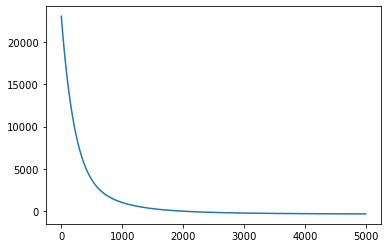

In [12]:
steps_gradient_decent = 5000
lost = []
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = model.negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)
        print('mu',mu.numpy())
        print('loss',loss.numpy())
        print('dmu',dlossdmu.numpy())
    mu = mu-tf.multiply(constant64(0.0001),dlossdmu)
plt.plot(lost)
MAP = mu

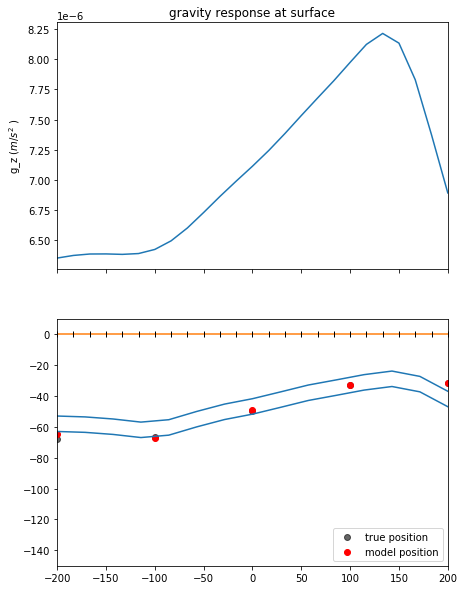

In [13]:
Draw(control_index,MAP, True_position_sin)

## SVGD

In [21]:
def svgd_kernel(X0):
    XY = tf.matmul(X0, tf.transpose(X0))
    X2_ = tf.reduce_sum(tf.square(X0), axis=1)

    x2 = tf.reshape(X2_, shape=(tf.shape(X0)[0], 1))

    X2e = tf.tile(x2, [1, tf.shape(X0)[0]])
    
    ## (x1 -x2)^2 + (y1 -y2)^2
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e)), 2 * XY)

    V = tf.reshape(H, [-1, 1])

    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(
        0.5 * h / tf.math.log(tf.cast(tf.shape(X0)[0], tf.float64) + 1.0))

    # compute the rbf kernel
    Kxy = tf.exp(-H / h ** 2 / 2.0)

    dxkxy = tf.negative(tf.matmul(Kxy, X0))
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), 1)
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (h ** 2)

    return (Kxy, dxkxy)

In [34]:
lr = constant64(0.004)
num_iter = 5000
num_particles = 200

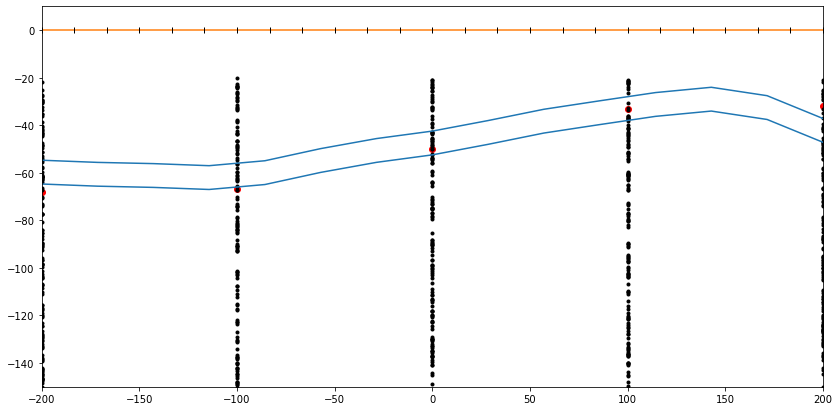

In [47]:
mu = tf.random.uniform([num_particles,Number_para],-200,-20,dtype = tf.float64)
_,ax = plt.subplots(figsize = (14,7))
ax.plot(x,mu,'k.')
Draw_inter(control_index,True_position_sin,ax=ax)

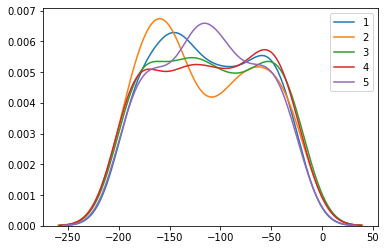

In [48]:
import seaborn as sns
sns.kdeplot(mu[:,0].numpy(),label = '1')
sns.kdeplot(mu[:,1].numpy(),label = '2')
sns.kdeplot(mu[:,2].numpy(),label = '3')
sns.kdeplot(mu[:,3].numpy(),label = '4')
sns.kdeplot(mu[:,4].numpy(),label = '5')

In [36]:
def gradient(mu):
    log_p_grad = tf.TensorArray(tf.float64, size=num_particles)
    for i in range(mu.shape[0]):
        with tf.GradientTape() as t:
            t.watch(mu)
            f = model.joint_log_post(Data,mu[i])
        log_p_grad =log_p_grad.write(i, t.gradient(f,mu)[i])
    return log_p_grad.stack()

In [37]:
x = np.linspace(Range[0],Range[1],Number_para)
x = np.reshape(np.tile(x,num_particles),[num_particles,Number_para])

In [38]:
@tf.function
def svgd_one_iter(mu):
    log_p_grad = gradient(mu)
    kernel_matrix, kernel_gradients = svgd_kernel(mu)
    grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
    mu = mu+lr*grad_theta
    return mu

def run_chain_svgd(mu):
    for i in range(num_iter):
        mu = svgd_one_iter(mu)
    return mu

In [39]:
mu = run_chain_svgd(mu)

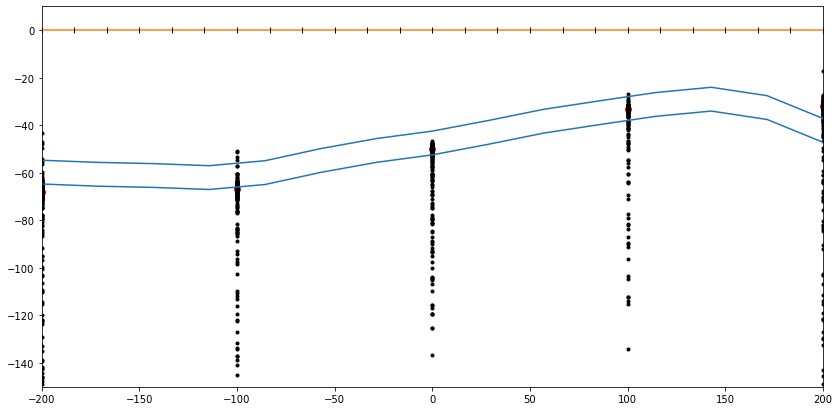

In [40]:
 _,ax = plt.subplots(figsize = (14,7))
ax.plot(x,mu,'k.')
Draw_inter(control_index,True_position_sin,ax=ax)

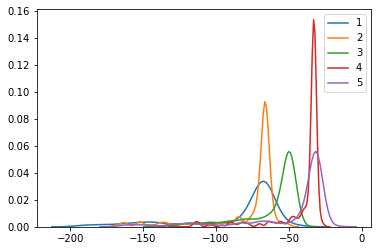

In [45]:
import seaborn as sns
sns.kdeplot(mu[:,0].numpy(),label = '1')
sns.kdeplot(mu[:,1].numpy(),label = '2')
sns.kdeplot(mu[:,2].numpy(),label = '3')
sns.kdeplot(mu[:,3].numpy(),label = '4')
sns.kdeplot(mu[:,4].numpy(),label = '5')
